## Unsupervised Outlier Detection

1. Detect anomalies on seperate 3 seperate datasets 
    - Use different anomaly thresholds (1% -5%) 
    - And compare/verify similar dates and relationship 
    - Create a ranking/voting system for "popular" anomaly dates 
    - Additionally use Leave-one out method
2. Same but merge 3 datasets 
3. Create labels from anomalies and run supervised models
4. Optimization
5. Build a website 

## Prof Notes:
- which gets similar results to ensable
- dif models and contamination, and optimization

https://towardsdatascience.com/in-12-minutes-stocks-analysis-with-pandas-and-scikit-learn-a8d8a7b50ee7
https://stackoverflow.com/questions/47211866/how-to-mark-specific-data-points-in-matplotlib-graph

In [47]:
import warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

# Import all models
import sklearn
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.loci import LOCI
from pyod.models.lscp import LSCP
from pyod.models.mcd import MCD
from pyod.models.mo_gaal import MO_GAAL
from pyod.models.ocsvm import OCSVM
from pyod.models.sos import SOS
from pyod.models.vae import VAE
# from pyod.models.xgbod import XGBOD 

# packages to predict anomalies 
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn import metrics, model_selection
from sklearn.metrics import classification_report,roc_auc_score,accuracy_score,confusion_matrix
from sklearn.metrics import roc_curve,f1_score,precision_recall_fscore_support

from scipy import stats
import matplotlib.pyplot as plt
pd.options.display.max_rows = 365
pd.set_option('display.max_columns',100)

## Test on each Dataset Seperetly 

### Price Dataset
- load in data and scale

In [32]:
# read in data
price = pd.read_csv('btc_preprocessed.csv', index_col = 0)
# scale the data function using min-max
def scale(df):
    cols = df.columns
    index = df.index
    scaler = MinMaxScaler()
    X = scaler.fit_transform(df)
    X = pd.DataFrame(X)
    X.columns = cols
    X = X.set_index(index)
    return X
# save results in variable X
X = scale(price)
print(X.shape)
# data is standerdized 
X.describe()

(365, 49)


,close,high,low,open,volumefrom,volumeto,CCI,ichimoku_leadSpanA,ichimoku_leadSpanB,MACD,...,ema_5,ema_10,ema_20,ema_30,ema_50,ema_100,ema_200,vwma,hull_Moving,Mkt_Cap
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,...,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,0.309506,0.323185,0.314349,0.311447,0.158511,0.165547,0.610031,0.360129,0.336818,0.567335,...,0.340866,0.341051,0.342827,0.340625,0.333706,0.318544,0.299443,0.373789,0.382758,0.312638
std,0.173618,0.181712,0.171755,0.174608,0.120752,0.150214,0.147846,0.207782,0.236865,0.167418,...,0.195385,0.203388,0.210658,0.215703,0.221806,0.226211,0.227650,0.186165,0.189751,0.172265
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.225885,0.230769,0.236921,0.226146,0.077413,0.061453,0.505965,0.254712,0.192137,0.470921,...,0.242474,0.231902,0.218803,0.202378,0.178738,0.152300,0.130824,0.282522,0.295410,0.232673
50%,0.264223,0.276441,0.267946,0.264287,0.124178,0.117303,0.592183,0.305660,0.234630,0.598206,...,0.287933,0.285601,0.273462,0.257315,0.255200,0.249962,0.231692,0.336388,0.337407,0.263083
75%,0.386708,0.406506,0.391708,0.390215,0.211678,0.220504,0.726902,0.458545,0.416687,0.650943,...,0.428683,0.437853,0.411689,0.418349,0.430019,0.422910,0.401396,0.498581,0.483048,0.386545
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 1.1 Run Models 

- VAE neurons adjusted (default nbr of neurons too much for blockchain dataset) 
    - for innitial run I would like to keep all the same
- VAE returns:<br>
UserWarning: Output model_2 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_2.

In [33]:
# time the code
import time
t0 = time.time()

# empty list to store outliers and inliners
df_outliers = []
scores_pred_lst = []
proba_lst = []
predict_rank_lst = []

# iterate over different outlier fractions 
outliers_fraction = [0.01,0.02,0.03,0.04,0.05]
random_state = 123 # set random state

for fraction in outliers_fraction:
    
    # Define 13 outlier detection tools to be compared
    classifiers = {#'AE' : AutoEncoder(contamination=outliers_fraction, random_state=random_state), # check why error
               'ABOD': ABOD(contamination = fraction),
              'CBLOF':CBLOF(check_estimator=False, random_state=random_state), # getting 0 
              'FB':FeatureBagging(LOF(n_neighbors=35),contamination=fraction,check_estimator=False,random_state=random_state),
              'HBOS': HBOS(contamination=fraction),
              'IF': IForest(contamination=fraction,random_state=random_state),
              'KNN': KNN(contamination=fraction),
              'Average KNN': KNN(method='mean',contamination=fraction),
              'OCSVM' : OCSVM(contamination=fraction),
              'SOS' : SOS(contamination=fraction),
              'LOF': LOF(n_neighbors=35, contamination = fraction),
              #'LOCI': LOCI(contamination = fraction), # takes a super long time + don't understand
              'VAE' : VAE(contamination=fraction, random_state=random_state) 
              }
    
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        clf.fit(X)
        # predict raw anomaly score
        scores_pred = clf.decision_function(X) * -1 # WHY? * -1

        # prediction of a datapoint category outlier or inlier
        y_pred = clf.predict(X)

        # probability of outlier 
        probability = clf.predict_proba(X, method = 'linear')

        # predict rank
        predict_rank = clf._predict_rank(X)

        n_inliers = len(y_pred) - np.count_nonzero(y_pred)
        n_outliers = np.count_nonzero(y_pred == 1)

        # copy of dataframe
        dfx = X.copy()

        dfx[clf_name] = y_pred.tolist()
        #print(clf_name,'\n',i,clf,'\n',classifiers,'\n',classifiers.items())
        print('Outlier fraction: ', fraction)
        print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        #print('scores_pred: ', scores_pred)
        scores_pred_lst.append(scores_pred)
        df_outliers.append(dfx[clf_name]) 
        proba_lst.append(probability)
        predict_rank_lst.append(predict_rank)
t1 = time.time()
total = t1-t0

Outlier fraction:  0.01
OUTLIERS :  5 INLIERS :  360 ABOD
Outlier fraction:  0.01
OUTLIERS :  37 INLIERS :  328 CBLOF
Outlier fraction:  0.01
OUTLIERS :  0 INLIERS :  365 FB
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 HBOS
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 IF
Outlier fraction:  0.01
OUTLIERS :  3 INLIERS :  362 KNN
Outlier fraction:  0.01
OUTLIERS :  1 INLIERS :  364 Average KNN
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 OCSVM
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 SOS
Outlier fraction:  0.01
OUTLIERS :  2 INLIERS :  363 LOF
Model: "model_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 49)           0                                            
__________________________________________________________________________________________________
den

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_32 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_32.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 49)                0         
_________________________________________________________________
model_31 (Model)             [(None, 2), (None, 2), (N 19318     
_________________________________________________________________
model_32 (Model)             (None, 49)                16855     
Total params: 36,173
Trainable params: 36,173
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 115.9066 - val_loss: 92.4074
Epoch 2/100
328/328 [==============================] - 0s 105us/step - loss: 76.2946 - val_loss: 75.0129
Epoch 3/100
328/328 [==============================] - 0s 103us/step - loss: 64.3727 - val_loss: 67.2832
Epoch 4/100
328/328 [====

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_35 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_35.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 49)                0         
_________________________________________________________________
model_34 (Model)             [(None, 2), (None, 2), (N 19318     
_________________________________________________________________
model_35 (Model)             (None, 49)                16855     
Total params: 36,173
Trainable params: 36,173
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 113.5759 - val_loss: 60.4550
Epoch 2/100
328/328 [==============================] - 0s 105us/step - loss: 76.7834 - val_loss: 50.6607
Epoch 3/100
328/328 [==============================] - 0s 105us/step - loss: 65.8635 - val_loss: 47.0127
Epoch 4/100
328/328 [====

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_38 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_38.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 49)                0         
_________________________________________________________________
model_37 (Model)             [(None, 2), (None, 2), (N 19318     
_________________________________________________________________
model_38 (Model)             (None, 49)                16855     
Total params: 36,173
Trainable params: 36,173
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 110.3813 - val_loss: 76.7353
Epoch 2/100
328/328 [==============================] - 0s 103us/step - loss: 74.6572 - val_loss: 63.5580
Epoch 3/100
328/328 [==============================] - 0s 104us/step - loss: 63.0100 - val_loss: 56.1461
Epoch 4/100
328/328 [====

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_41 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_41.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 49)                0         
_________________________________________________________________
model_40 (Model)             [(None, 2), (None, 2), (N 19318     
_________________________________________________________________
model_41 (Model)             (None, 49)                16855     
Total params: 36,173
Trainable params: 36,173
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 114.9608 - val_loss: 82.4820
Epoch 2/100
328/328 [==============================] - 0s 103us/step - loss: 75.5328 - val_loss: 67.4224
Epoch 3/100
328/328 [==============================] - 0s 104us/step - loss: 64.1757 - val_loss: 60.6200
Epoch 4/100
328/328 [====

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_44 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_44.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 49)                0         
_________________________________________________________________
model_43 (Model)             [(None, 2), (None, 2), (N 19318     
_________________________________________________________________
model_44 (Model)             (None, 49)                16855     
Total params: 36,173
Trainable params: 36,173
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 100.4785 - val_loss: 88.9084
Epoch 2/100
328/328 [==============================] - 0s 107us/step - loss: 70.0945 - val_loss: 77.4383
Epoch 3/100
328/328 [==============================] - 0s 104us/step - loss: 61.3545 - val_loss: 70.9448
Epoch 4/100
328/328 [====

In [34]:
print('Time to run: ',total,'s')
print('Nbr of lists',len(df_outliers))

Time to run:  40.67471218109131 s
Nbr of lists 55


In [35]:
# save ranking table
#frequencies_df_price = frequencies_df
# save the outliers lists uniquely for later
prices_df = df_outliers
# probability lists
prices_proba = proba_lst
# rank lists
prices_rank_lst = predict_rank_lst

### 1.2 Seperate models per contamination
- Change if number of models change 

In [36]:
# seperate the outliers identified by models into lists by fraction 
# we know that it starts with 0.01 and how many models
frac_oo1 = df_outliers[0:11]
frac_oo2 = df_outliers[11:22]
frac_oo3 = df_outliers[22:33]
frac_oo4 = df_outliers[33:44]
frac_oo5 = df_outliers[44:]

# subset data so we only get dates where models identified them as outliers
def outlier_subset_function(outliers_lst):
# convert lists into df and transpose it
    btc_outliers = np.transpose(pd.DataFrame(outliers_lst))#.reset_index()
    
    outlier_dates = [] # this stores outlier dates
    #lenght = len(outlier_dates)
    for col in btc_outliers.columns:
        outliers = btc_outliers[btc_outliers[col] == 1] # subset outlier data
        outlier_dates.append(outliers.index.tolist()) # append the string/date 
        
        #lenght2 = len(outlier_dates)
        #nbr_dates = 
    return outlier_dates

In [37]:
# use the function to extract anomolous dates for each model and for each fraction
frac_oo1_outliers = outlier_subset_function(frac_oo1)
frac_oo2_outliers = outlier_subset_function(frac_oo2)
frac_oo3_outliers = outlier_subset_function(frac_oo3)
frac_oo4_outliers = outlier_subset_function(frac_oo4)
frac_oo5_outliers = outlier_subset_function(frac_oo5)

- depending on the following lenght, the number of lists to be joined in the function below is modified

In [38]:
# nbr of list = nbr of models
len(frac_oo1_outliers)

11

### 1.3 Get Unique Anomaly Dates per Contamination fraction
- purpuse of count_weight_outliers function is to find unique anomaly dates for a fraction 

**NOTE:** 
1. Nbr of lists in count_weight_outliers function has to be adjusted depending on how many models you are using
2. Weight_per_fraction col enumerator (division) needs to be changed depending on the number of models

In [39]:
def count_weight_outliers(outlier_dates): 
    # we have 11 anomaly model lists, joined them into one 
    # this function only does it for 1 fraction i.e. 0.01
    join =outlier_dates[0] + outlier_dates[1] + outlier_dates[2] + outlier_dates[3] + outlier_dates[4] +\
        outlier_dates[5] + outlier_dates[6] + outlier_dates[7] + outlier_dates[8] + outlier_dates[9] + outlier_dates[10]
    # find unique dates and count their occurance
    (unique, counts) = np.unique(join, return_counts=True)
    # convert this into an array from tuple
    frequencies = np.asarray((unique, counts)).T
    # now make it a dataframe
    frequencies_df = pd.DataFrame(frequencies)
    # name the columns so you can rever to them more easily 
    frequencies_df.columns = ['Date','Count_Anomaly_Date']
    # convert rank to integer type 
    frequencies_df.Count_Anomaly_Date = frequencies_df.Count_Anomaly_Date.astype(int)
    # how many times 11 models identified date as an anomaly for 1 fraction
        # again nbr of models for each fraction is 11, divide how many models identified the anomaly for specific date
        # with the number of total models = 11 
    frequencies_df['Weight_per_fraction'] = frequencies_df['Count_Anomaly_Date']/11 # ALTER THIS if nbr models changes
    # sort the dataframe by count of models that identified a specific date as anomaly
    frequencies_df = frequencies_df.sort_values(by='Count_Anomaly_Date', ascending = False)
    return frequencies_df

- **dates_per_fraction function** makes a dataframe to display number of anomaly dates per ALL fraction   

In [40]:
def dates_per_fraction(l1,l2,l3,l4,l5):
    # because we want to know nbr of unique anomalies per dates for all fraction we concat all on axis = 1
    d1 = pd.concat([count_weight_outliers(l1),count_weight_outliers(l2),count_weight_outliers(l3),
                    count_weight_outliers(l4),count_weight_outliers(l5)],axis=1)
    # As all columns now have the same names due to our count_weight_outliers I rename the columns
    d1.columns = ['001','Count1','W1','002','Count2','W2','003','Count3','W3','004','Count4','W4','005',
                'Count5','W5']
    
    # to nicely display all anomaly date fractions in 1 output we convert compute value_counts for the date
    # these are already unique dates so this returns nbr 1 for each date 
    d01 = d1['001'].value_counts()
    d02 = d1['002'].value_counts()
    d03 = d1['003'].value_counts()
    d04 = d1['004'].value_counts()
    d05 = d1['005'].value_counts()
    # concat these value counts now i.e. when one fraction has a values it will display 1 
        # when other doesnt it will display NaN
    l = pd.concat([d01,d02,d03,d04,d05],axis=1, sort=True)
    # to replace NaN with 0 when one fraction doesn't have that anomaly date we groupe it by count
        # the other way would be to replace NaN with 0
    l = l.groupby(l.index)['001','002','003','004','005'].agg('count')
    
    #lw = l.merge(d1[['001','W1']],left_on=l.index, right_on=d1['001'])
    #lw = l.merge(d1[['002','W2']],left_on=l.index, right_on=d1['002'])
    
    # here we sum up all the counts to get the total number of anomalies per fraction
    print('Outlier fraction 0.01 unique dates: ',l['001'].sum())
    print('Outlier fraction 0.02 unique dates: ',l['002'].sum())
    print('Outlier fraction 0.03 unique dates: ',l['003'].sum())
    print('Outlier fraction 0.04 unique dates: ',l['004'].sum())
    print('Outlier fraction 0.05 unique dates: ',l['005'].sum())
    # but we also want to see the df for all fraction so we return l
    return #l

dates_per_fraction(frac_oo1_outliers,frac_oo2_outliers,frac_oo3_outliers,frac_oo4_outliers,frac_oo5_outliers)

Outlier fraction 0.01 unique dates:  44
Outlier fraction 0.02 unique dates:  51
Outlier fraction 0.03 unique dates:  57
Outlier fraction 0.04 unique dates:  65
Outlier fraction 0.05 unique dates:  73


### 1.4 Anomaly Likelihood
- Assumption1: if all contamination levels vote for a date the date is more likely to be an anomaly
- Assumption2: if more models vote for a date the date is more likely to be an anomaly 
- So if both assumtions are true we could say date is even more likely to be an anomaly

In [41]:
# all fraction anomalous dates found merged 
def date_ranking(df1, df2, df3, df4, df5):
    # concat all the fractions into 1 dataframe on rows (axis = 0)
    # here we have duplicate values as some fractions/models identified same dates 
    concat = pd.concat([count_weight_outliers(df1),count_weight_outliers(df2),
            count_weight_outliers(df3),count_weight_outliers(df4), count_weight_outliers(df5)], 
            axis = 0)
    concat.columns = ['Date','ModelAnomaly_Vote','Weight_per_fraction']
    # count_weight_outliers function provides unique dates per contamination level
        # so if we group/value_counts on date, the date can be counted 5 times max as we have 1%-5% contamination
    # here we answer how many times a date was selected in ALL fractions (0.01 - 0.05) 
    allFractions_dateAnomaly = pd.DataFrame(concat.Date.value_counts()).reset_index()
    allFractions_dateAnomaly.columns = ['Date','AllContaminations_Vote']
 
    # how many models voted in all fractions combined 
    # sum of nbr of models that selected a date as an anomaly (in all contamination levels)
    model_vote = pd.DataFrame(concat.groupby("Date")['ModelAnomaly_Vote'].agg('sum')).reset_index()
    
    # sum the number of models that voted for a date (in all contamination levels)
    sum_ModelVotes = concat['ModelAnomaly_Vote'].sum()
    
    # merge it with anomalyCount_Fractions df so that dates match 
    merged_inner = pd.merge(left=allFractions_dateAnomaly, right=model_vote, on='Date')
    
    # model vote weight - if more models voted for a date we could assume its more likely an anomaly
    # model votes for 1 date / total model anomaly votes (665) in all contamination levels
    merged_inner['weight_anomaly_models'] = merged_inner.ModelAnomaly_Vote/sum_ModelVotes
    
    # Sort based on highest contamination anomaly count and highest model anomaly vote
    merged_inner = merged_inner.sort_values(["AllContaminations_Vote", "ModelAnomaly_Vote"], ascending = (False, False))
    return merged_inner

In [42]:
price_anomalies = date_ranking(frac_oo1_outliers,frac_oo2_outliers,frac_oo3_outliers,frac_oo4_outliers,frac_oo5_outliers)
print('Unique Anomaly Dates: ',len(price_anomalies.Date.unique()))
price_anomalies

Unique Anomaly Dates:  73


,Date,AllContaminations_Vote,ModelAnomaly_Vote,weight_anomaly_models
34,2018-01-16,5,36,0.054054
33,2018-01-17,5,32,0.048048
19,2018-01-06,5,31,0.046547
3,2018-01-01,5,30,0.045045
4,2018-01-05,5,29,0.043544
7,2018-01-07,5,24,0.036036
5,2018-01-08,5,22,0.033033
8,2018-01-03,5,21,0.031532
18,2018-01-02,5,21,0.031532
32,2018-01-04,5,20,0.030030


## 1.4.1 Predicting anomalies with XGBOOST - Price
- all features used

(365, 49)

(365,)

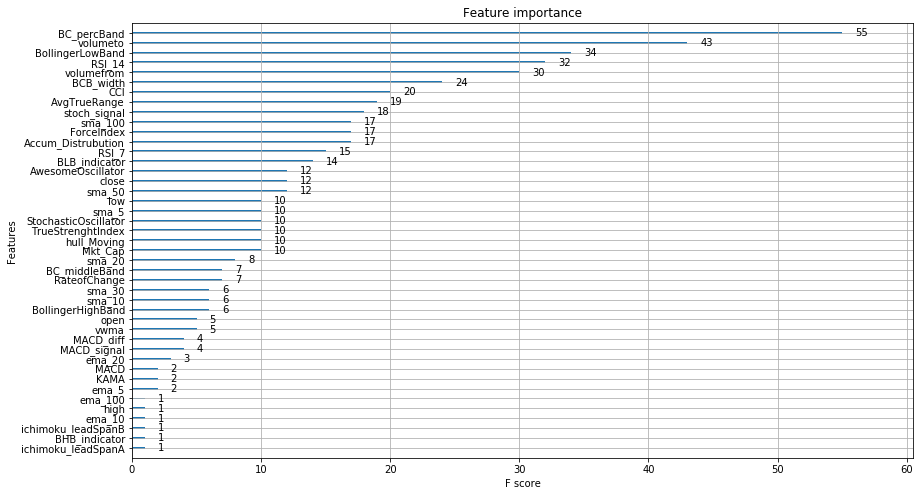

F1 0.9260; AUC 0.9755 
Model is predicting  [0. 1.] class
Accuracy of classifier on test set: 0.890
10-fold cross validation average accuracy of clf: 0.927
Confusion Matrix for Classfier:
[[55  3]
 [ 5 10]]
Classification Report for Classfier:
              precision    recall  f1-score   support

         0.0       0.92      0.95      0.93        58
         1.0       0.77      0.67      0.71        15

    accuracy                           0.89        73
   macro avg       0.84      0.81      0.82        73
weighted avg       0.89      0.89      0.89        73



In [43]:
# subset the original price dataframe and get its values
#anomaly_dates_df = price[price.index.isin(price_anomaly_dates)]

# make a new column if date was identified as an anomaly
anomaly_dates_modeling = price_anomalies.iloc[:,0]
price['anomaly'] = np.where(price.index.isin(anomaly_dates_modeling), 1, 0)

# standerdize 
anomalies_classified = scale(price)
# create labels and target variable
X1 = anomalies_classified.drop('anomaly', axis=1)
y1 = anomalies_classified['anomaly']
# shape of X and y
display(X1.shape)
display(y1.shape)

# feature selection: plot feature importance using built-in function  
# fit the model
model = XGBClassifier(random_state=123)
model.fit(X1, y1)
# plot feature importance
plt.rcParams["figure.figsize"] = (14, 8)
plot_importance(model)
plt.show()

# modeling
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=123, shuffle = True)

# this is the formula after you split the dataset
sm = SMOTE(random_state=123, sampling_strategy = 'minority')
x_train_res, y_train_res = sm.fit_sample(X_train, y_train)

# fit model no training data
clf = XGBClassifier(random_state=123)

clf.fit(x_train_res, y_train_res)

# make predictions for test data
y_pred = clf.predict(X_test)
predictions = [round(value) for value in y_pred]

#10-fold cross validation
kfold = model_selection.KFold(n_splits=10, random_state=123, shuffle = True)
scoring = 'accuracy'
results = model_selection.cross_val_score(clf, x_train_res, y_train_res, cv=kfold, scoring=scoring)

# average is the bias, and std dev is variance
f1_scores = model_selection.cross_val_score(clf, x_train_res, y_train_res, cv=kfold, scoring='f1')
roc_scores = model_selection.cross_val_score(clf, x_train_res, y_train_res, cv=kfold, scoring='roc_auc')

#calculate f1-score and AUC
clf_roc_auc = roc_auc_score(y_test, y_pred)

# average F1 and AUC through 10 fold cross-validation
print('F1 {:.4f}; AUC {:.4f} '.format(f1_scores.mean(),roc_scores.mean()))

# Is our model still predicting just one class?
print('Model is predicting ',np.unique( y_pred ),'class' )

print('Accuracy of classifier on test set: {:.3f}'.format(clf.score(X_test, y_test)))

print("10-fold cross validation average accuracy of clf: %.3f" % (results.mean()))

confusion_matrix_y = confusion_matrix(y_test, y_pred)
print('Confusion Matrix for Classfier:')
print(confusion_matrix_y)

print('Classification Report for Classfier:')
print(classification_report(y_test, y_pred))

## 1.4.2 Data statistics where anomaly = 1 and anomaly = 0

In [48]:
print('Where anomaly = 1:')
display(anomalies_classified[anomalies_classified['anomaly']==1].describe())
print('Where anomaly = 0:')
anomalies_classified[anomalies_classified['anomaly']==0].describe()

Where anomaly = 1:


,close,high,low,open,volumefrom,volumeto,CCI,ichimoku_leadSpanA,ichimoku_leadSpanB,MACD,MACD_diff,MACD_signal,AwesomeOscillator,KAMA,RateofChange,RSI_7,RSI_14,StochasticOscillator,stoch_signal,TrueStrenghtIndex,UltimateOscilator,williamsR,Accum_Distrubution,ForceIndex,AvgTrueRange,BollingerHighBand,BHB_indicator,BollingerLowBand,BLB_indicator,BC_middleBand,BC_percBand,BCB_width,sma_5,sma_10,sma_20,sma_30,sma_50,sma_100,sma_200,ema_5,ema_10,ema_20,ema_30,ema_50,ema_100,ema_200,vwma,hull_Moving,Mkt_Cap,anomaly
count,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.0
mean,0.404738,0.434413,0.399428,0.415488,0.248306,0.292934,0.557923,0.498531,0.487357,0.570528,0.456502,0.639621,0.596516,0.428094,0.323520,0.406325,0.390747,0.407034,0.414227,0.475798,0.475798,0.407034,0.619466,0.336519,0.327024,0.500557,0.082192,0.489133,0.315068,0.500721,0.467101,0.392509,0.421528,0.416949,0.382071,0.383360,0.385580,0.361083,0.411234,0.470330,0.480364,0.486889,0.485885,0.479760,0.466706,0.451825,0.384003,0.423716,0.406523,1.0
std,0.267564,0.278393,0.264112,0.269272,0.172676,0.216435,0.204158,0.325569,0.353007,0.209107,0.200249,0.209853,0.198946,0.289566,0.158216,0.282128,0.244421,0.321660,0.298486,0.276474,0.276474,0.321660,0.213366,0.190339,0.335131,0.342481,0.276557,0.301006,0.467758,0.325468,0.243419,0.191812,0.276168,0.269446,0.225985,0.201793,0.141613,0.156336,0.139728,0.302947,0.315955,0.324858,0.330102,0.337016,0.344402,0.349838,0.228934,0.248970,0.265237,0.0
min,0.022646,0.026313,0.005301,0.001640,0.030878,0.018640,0.000000,0.004081,0.006206,0.016251,0.000000,0.076838,0.000000,0.000000,0.000000,0.000000,0.000000,0.014622,0.008158,0.000000,0.000000,0.014622,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000975,0.001069,0.000000,0.005075,0.050120,0.038911,0.037856,0.001407,0.000140,0.009927,0.014159,0.016257,0.015253,0.012983,0.001524,0.007767,0.023769,1.0
25%,0.218978,0.232538,0.225774,0.223349,0.133717,0.126811,0.409417,0.247223,0.185224,0.461825,0.317343,0.528491,0.515575,0.214010,0.230822,0.189630,0.234081,0.150117,0.170191,0.287425,0.287425,0.150117,0.442657,0.280022,0.109383,0.209796,0.000000,0.277544,0.000000,0.237884,0.284408,0.257338,0.241532,0.253698,0.273673,0.296744,0.338909,0.298012,0.423278,0.240221,0.230536,0.214578,0.197452,0.172121,0.143415,0.121338,0.277773,0.293822,0.223183,1.0
50%,0.301424,0.333352,0.295063,0.307076,0.213520,0.256969,0.538086,0.367726,0.342299,0.592968,0.463448,0.657278,0.651317,0.302741,0.340807,0.370435,0.363507,0.278368,0.301380,0.388690,0.388690,0.278368,0.677045,0.318049,0.189306,0.380400,0.000000,0.363372,0.000000,0.367884,0.430364,0.398588,0.290259,0.297525,0.331057,0.359251,0.384374,0.363752,0.432303,0.331639,0.355722,0.365564,0.366862,0.375226,0.360815,0.334634,0.336388,0.337407,0.303307,1.0
75%,0.594647,0.628880,0.586844,0.594557,0.299673,0.397606,0.713223,0.788806,0.821087,0.685032,0.598253,0.780344,0.714493,0.679805,0.397374,0.598653,0.490807,0.765634,0.743800,0.665564,0.665564,0.765634,0.803056,0.338642,0.499275,0.937626,0.000000,0.719986,1.000000,0.869227,0.665234,0.519889,0.639073,0.608328,0.382486,0.365110,0.384374,0.363752,0.432303,0.743956,0.797483,0.823221,0.831604,0.834605,0.829843,0.821104,0.395067,0.550622,0.592373,1.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.929186,1.000000,1.000000,1.000000,0.741606,1.000000,1.000000,0.985632,0.970257,1.000000,1.000000,0.985632,0.914976,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.83197

Where anomaly = 0:


,close,high,low,open,volumefrom,volumeto,CCI,ichimoku_leadSpanA,ichimoku_leadSpanB,MACD,MACD_diff,MACD_signal,AwesomeOscillator,KAMA,RateofChange,RSI_7,RSI_14,StochasticOscillator,stoch_signal,TrueStrenghtIndex,UltimateOscilator,williamsR,Accum_Distrubution,ForceIndex,AvgTrueRange,BollingerHighBand,BHB_indicator,BollingerLowBand,BLB_indicator,BC_middleBand,BC_percBand,BCB_width,sma_5,sma_10,sma_20,sma_30,sma_50,sma_100,sma_200,ema_5,ema_10,ema_20,ema_30,ema_50,ema_100,ema_200,vwma,hull_Moving,Mkt_Cap,anomaly
count,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.000000,292.0
mean,0.285698,0.295378,0.293079,0.285437,0.136062,0.133701,0.623057,0.325528,0.299184,0.566537,0.521463,0.597707,0.646154,0.276244,0.375326,0.434795,0.392465,0.446905,0.437902,0.351077,0.351077,0.446905,0.782242,0.317908,0.284989,0.314041,0.010274,0.317741,0.006849,0.317371,0.546574,0.385182,0.305661,0.324794,0.365119,0.399346,0.456327,0.426079,0.453884,0.308499,0.306222,0.306811,0.304310,0.297193,0.281503,0.261348,0.371235,0.372518,0.289167,0.0
std,0.130950,0.135082,0.131800,0.129623,0.091286,0.107453,0.127191,0.147552,0.179557,0.155686,0.129109,0.186986,0.171971,0.130675,0.142071,0.158557,0.113670,0.290802,0.294912,0.114038,0.114038,0.290802,0.092635,0.026916,0.189365,0.167635,0.101012,0.135597,0.082618,0.149019,0.162917,0.213821,0.139666,0.147642,0.171439,0.175008,0.197192,0.204541,0.175795,0.140671,0.144770,0.151294,0.156915,0.163549,0.166664,0.165115,0.174216,0.170807,0.130190,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.295560,0.000000,0.000000,0.000000,0.233819,0.000000,0.016366,0.000002,0.027226,0.093191,0.061998,0.000000,0.000000,0.002229,0.002229,0.000000,0.511025,0.199847,0.063223,0.001642,0.000000,0.001227,0.000000,0.000412,0.223579,0.048504,0.000000,0.000000,0.000474,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.226984,0.230764,0.239948,0.226802,0.071874,0.057521,0.518338,0.254840,0.192137,0.472767,0.454400,0.493846,0.539679,0.215532,0.281655,0.305164,0.316037,0.201148,0.178985,0.286039,0.286039,0.201148,0.730331,0.310872,0.172761,0.193539,0.000000,0.279737,0.000000,0.240447,0.410013,0.228393,0.243060,0.256443,0.276621,0.302798,0.339319,0.304831,0.432303,0.243276,0.232025,0.218916,0.202850,0.179634,0.153650,0.132302,0.283036,0.296258,0.234558,0.0
50%,0.255203,0.264268,0.267660,0.256094,0.111873,0.096613,0.597833,0.286228,0.232522,0.599893,0.518408,0.635590,0.675630,0.250851,0.377103,0.427281,0.390943,0.378366,0.366833,0.356940,0.356940,0.378366,0.791262,0.322417,0.209364,0.290966,0.000000,0.311433,0.000000,0.294222,0.518380,0.363570,0.281787,0.297000,0.338487,0.364125,0.384374,0.363752,0.432303,0.281174,0.273142,0.264208,0.254844,0.242815,0.237573,0.219980,0.345416,0.334914,0.256718,0.0
75%,0.360845,0.379161,0.373086,0.362600,0.181604,0.182625,0.727060,0.440693,0.397828,0.650091,0.577372,0.702642,0.731703,0.377340,0.457478,0.551611,0.465977,0.688797,0.709257,0.415625,0.415625,0.688797,0.846808,0.327627,0.324788,0.415764,0.000000,0.380017,0.000000,0.427372,0.682009,0.510905,0.388773,0.424585,0.491670,0.525329,0.586552,0.511257,0.438974,0.414924,0.411339,0.397168,0.387535,0.379247,0.364251,0.343963,0.504857,0.477400,0.363793,0.0
max,0.593403,0.614296,0.629869,0.612196,0.533622,0.551031,0.950166,0.763181,0.821087,0.853366,1.000000,0.942668,0.992520,0.639195,1.000000,0.824674,0.678743,1.000000,1.000000,0.606123,0.606123,1.000000,1.000000,0.419746,0.935628,0.949291,1.

### 1.5 Borderline probability analysis
- e.g. the probability was 51% that date is an anomaly --> whats the realtionships
    - I think it's similar to predict() where I get labels not ratios (based on threshold it labels?)
    - predict_proba(): Predict the probability of a sample being outlier using the fitted detector.
    - simply use Min-max conversion to linearly transform the outlier scores into the range of [0,1]. 
    - Description of labeling formula vs probabilty:
    https://pyod.readthedocs.io/en/latest/_modules/pyod/models/base.html#BaseDetector.predict

In [45]:
#import sys
np.set_printoptions(threshold=100)
prices_proba[0][:10]

array([[2.26869892e-07, 9.99999773e-01],
       [1.22951083e-04, 9.99877049e-01],
       [3.55243856e-04, 9.99644756e-01],
       [4.31716397e-04, 9.99568284e-01],
       [3.90444856e-05, 9.99960956e-01],
       [1.49117160e-05, 9.99985088e-01],
       [8.06483994e-05, 9.99919352e-01],
       [3.57676071e-05, 9.99964232e-01],
       [2.57806667e-05, 9.99974219e-01],
       [1.64204572e-05, 9.99983580e-01]])

## 2. Blockhain Dataset 
- **Note**
    - no feature engineering added to this dataset
    - as we defined functions above here we only need to call them on a new dataset 
    - exeption is model code so we can adjust the hyperparameters

In [49]:
block = pd.read_csv('blockchain18.csv', index_col = 0)
X = scale(block)
print(X.shape)
X.describe()

(365, 14)


,active_addresses,average_transaction_value,block_height,block_size,block_time,current_supply,difficulty,hashrate,large_transaction_count,new_addresses,transaction_count,transaction_count_all_time,unique_addresses_all_time,zero_balance_addresses_all_time
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,0.312659,0.224696,0.513188,0.577511,0.325309,0.513188,0.550890,0.476739,0.170867,0.224342,0.303136,0.482607,0.507523,0.518616
std,0.171182,0.136495,0.290541,0.223873,0.162468,0.290539,0.301799,0.243572,0.152479,0.133257,0.152195,0.275745,0.276457,0.275090
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.212106,0.132698,0.262062,0.417905,0.210205,0.262065,0.287124,0.268642,0.098229,0.151384,0.198545,0.246273,0.271502,0.300481
50%,0.279694,0.196649,0.517795,0.610013,0.302476,0.517790,0.575492,0.476230,0.134256,0.212049,0.281559,0.464341,0.496377,0.509794
75%,0.361409,0.287395,0.770601,0.771129,0.417515,0.770599,0.855096,0.684369,0.189775,0.265077,0.394768,0.709336,0.739602,0.748531
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 2.1 Run Models

- Adjusted neurons for VAE (not enogh features for default setting)

In [50]:
# time the code
import time
t0 = time.time()

# empty list to store outliers and inliners
df_outliers = []
scores_pred_lst = []
proba_lst = []
predict_rank_lst = []

for fraction in outliers_fraction:
    # Define 13 outlier detection tools to be compared
    classifiers = {#'AE' : AutoEncoder(contamination=outliers_fraction, random_state=random_state), # check why error
               'ABOD': ABOD(contamination = fraction),
              'CBLOF':CBLOF(check_estimator=False, random_state=random_state), # getting 0 
              'FB':FeatureBagging(LOF(n_neighbors=35),contamination=fraction,check_estimator=False,random_state=random_state),
              'HBOS': HBOS(contamination=fraction),
              'IF': IForest(contamination=fraction,random_state=random_state),
              'KNN': KNN(contamination=fraction),
              'Average KNN': KNN(method='mean',contamination=fraction),
              'OCSVM' : OCSVM(contamination=fraction),
              'SOS' : SOS(contamination=fraction),
              'LOF': LOF(n_neighbors=35, contamination = fraction),
              #'LOCI': LOCI(contamination = fraction), # takes a super long time + don't understand
              'VAE' : VAE(contamination=fraction, random_state=random_state,encoder_neurons=[56, 28, 14],
                         decoder_neurons=[14,28,56]) # default nbr of neurons too much for blockchain dataset
              }

    for i, (clf_name, clf) in enumerate(classifiers.items()):
        clf.fit(X)
        # predict raw anomaly score
        scores_pred = clf.decision_function(X) * -1 # WHY? * -1

        # prediction of a datapoint category outlier or inlier
        y_pred = clf.predict(X)

        # probability of outlier 
        probability = clf.predict_proba(X, method = 'linear')

        # predict rank
        predict_rank = clf._predict_rank(X)

        n_inliers = len(y_pred) - np.count_nonzero(y_pred)
        n_outliers = np.count_nonzero(y_pred == 1)

        # copy of dataframe
        dfx = X.copy()

        dfx[clf_name] = y_pred.tolist()
        #print(clf_name,'\n',i,clf,'\n',classifiers,'\n',classifiers.items())
        print('Outlier fraction: ', fraction)
        print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        #print('scores_pred: ', scores_pred)
        scores_pred_lst.append(scores_pred)
        df_outliers.append(dfx[clf_name]) 
        proba_lst.append(probability)
        predict_rank_lst.append(predict_rank)
t1 = time.time()
total = t1-t0

Outlier fraction:  0.01
OUTLIERS :  6 INLIERS :  359 ABOD
Outlier fraction:  0.01
OUTLIERS :  37 INLIERS :  328 CBLOF
Outlier fraction:  0.01
OUTLIERS :  3 INLIERS :  362 FB
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 HBOS
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 IF
Outlier fraction:  0.01
OUTLIERS :  3 INLIERS :  362 KNN
Outlier fraction:  0.01
OUTLIERS :  1 INLIERS :  364 Average KNN
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 OCSVM
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 SOS
Outlier fraction:  0.01
OUTLIERS :  3 INLIERS :  362 LOF
Model: "model_46"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           (None, 14)           0                                            
__________________________________________________________________________________________________
den

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_47 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_47.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 14)                0         
_________________________________________________________________
model_46 (Model)             [(None, 2), (None, 2), (N 3112      
_________________________________________________________________
model_47 (Model)             (None, 14)                2890      
Total params: 6,002
Trainable params: 6,002
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 32.6821 - val_loss: 22.3629
Epoch 2/100
328/328 [==============================] - 0s 102us/step - loss: 25.9132 - val_loss: 19.2190
Epoch 3/100
328/328 [==============================] - 0s 100us/step - loss: 21.9690 - val_loss: 17.3122
Epoch 4/100
328/328 [=======

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_50 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_50.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        (None, 14)                0         
_________________________________________________________________
model_49 (Model)             [(None, 2), (None, 2), (N 3112      
_________________________________________________________________
model_50 (Model)             (None, 14)                2890      
Total params: 6,002
Trainable params: 6,002
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 31.1330 - val_loss: 22.9256
Epoch 2/100
328/328 [==============================] - 0s 96us/step - loss: 25.4925 - val_loss: 20.1192
Epoch 3/100
328/328 [==============================] - 0s 95us/step - loss: 22.3576 - val_loss: 18.3892
Epoch 4/100
328/328 [=========

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_53 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_53.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        (None, 14)                0         
_________________________________________________________________
model_52 (Model)             [(None, 2), (None, 2), (N 3112      
_________________________________________________________________
model_53 (Model)             (None, 14)                2890      
Total params: 6,002
Trainable params: 6,002
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 42.1993 - val_loss: 33.5821
Epoch 2/100
328/328 [==============================] - 0s 97us/step - loss: 32.6497 - val_loss: 27.4079
Epoch 3/100
328/328 [==============================] - 0s 97us/step - loss: 27.2502 - val_loss: 23.7099
Epoch 4/100
328/328 [=========

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_56 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_56.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        (None, 14)                0         
_________________________________________________________________
model_55 (Model)             [(None, 2), (None, 2), (N 3112      
_________________________________________________________________
model_56 (Model)             (None, 14)                2890      
Total params: 6,002
Trainable params: 6,002
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 37.3721 - val_loss: 27.7191
Epoch 2/100
328/328 [==============================] - 0s 97us/step - loss: 28.7850 - val_loss: 23.7410
Epoch 3/100
328/328 [==============================] - 0s 99us/step - loss: 24.3608 - val_loss: 21.3002
Epoch 4/100
328/328 [=========

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_59 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_59.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        (None, 14)                0         
_________________________________________________________________
model_58 (Model)             [(None, 2), (None, 2), (N 3112      
_________________________________________________________________
model_59 (Model)             (None, 14)                2890      
Total params: 6,002
Trainable params: 6,002
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 31.1065 - val_loss: 27.1753
Epoch 2/100
328/328 [==============================] - 0s 101us/step - loss: 25.6109 - val_loss: 24.2365
Epoch 3/100
328/328 [==============================] - 0s 100us/step - loss: 22.4105 - val_loss: 21.9323
Epoch 4/100
328/328 [=======

In [51]:
print('Time to run: ',total,'s')
print('Nbr of lists: ',len(df_outliers))

Time to run:  36.12945890426636 s
Nbr of lists:  55


In [52]:
# save the outliers lists uniquely for later
block_df = df_outliers
# probability lists
block_proba = proba_lst
# rank lists
block_rank = predict_rank_lst

### 2.2 Seperate models per contamination

In [53]:
frac_oo1 = df_outliers[0:11]
frac_oo2 = df_outliers[11:22]
frac_oo3 = df_outliers[22:33]
frac_oo4 = df_outliers[33:44]
frac_oo5 = df_outliers[44:]
# use the function to extract the dates
frac_oo1_outliers = outlier_subset_function(frac_oo1)
frac_oo2_outliers = outlier_subset_function(frac_oo2)
frac_oo3_outliers = outlier_subset_function(frac_oo3)
frac_oo4_outliers = outlier_subset_function(frac_oo4)
frac_oo5_outliers = outlier_subset_function(frac_oo5)

### 2.3 Get Unique Anomaly Dates per Contamination fraction

In [54]:
dates_per_fraction(frac_oo1_outliers,frac_oo2_outliers,frac_oo3_outliers,frac_oo4_outliers,frac_oo5_outliers)

Outlier fraction 0.01 unique dates:  38
Outlier fraction 0.02 unique dates:  42
Outlier fraction 0.03 unique dates:  48
Outlier fraction 0.04 unique dates:  52
Outlier fraction 0.05 unique dates:  59


### 2.4 Anomaly Likelihood
- Assumption1: if all contamination levels vote for a date the date is more likely to be an anomaly
- Assumption2: if more models vote for a date the date is more likely to be an anomaly
- So if both assumtions are true we could say date is even more likely to be an anomaly

In [55]:
block_anomalies = date_ranking(frac_oo1_outliers,frac_oo2_outliers,frac_oo3_outliers,frac_oo4_outliers,frac_oo5_outliers)
print('Unique Anomaly Dates: ',len(block_anomalies.Date.unique()))
block_anomalies

Unique Anomaly Dates:  59


,Date,AllContaminations_Vote,ModelAnomaly_Vote,weight_anomaly_models
35,2018-01-04,5,48,0.068768
15,2018-03-17,5,38,0.054441
24,2018-01-03,5,36,0.051576
36,2018-01-05,5,36,0.051576
6,2018-01-06,5,31,0.044413
23,2018-01-09,5,28,0.040115
13,2018-01-07,5,27,0.038682
29,2018-01-28,5,27,0.038682
10,2018-01-02,5,26,0.037249
33,2018-01-11,5,26,0.037249


## 2.4.1 Predicting Anomalies with XGBOOST - Blockchain
- all features used

(365, 14)

(365,)

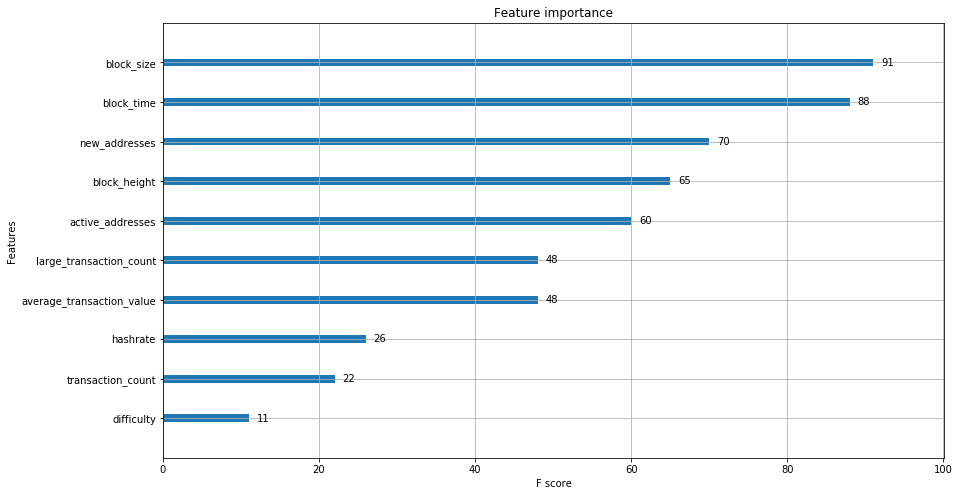

F1 0.9170; AUC 0.9661 
Model is predicting  [0. 1.] class
Accuracy of classifier on test set: 0.904
10-fold cross validation average accuracy of clf: 0.916
Confusion Matrix for Classfier:
[[59  3]
 [ 4  7]]
Classification Report for Classfier:
              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94        62
         1.0       0.70      0.64      0.67        11

    accuracy                           0.90        73
   macro avg       0.82      0.79      0.81        73
weighted avg       0.90      0.90      0.90        73



In [56]:
# make a new column if date was identified as an anomaly
anomaly_dates_modeling = block_anomalies.iloc[:,0]
block['anomaly'] = np.where(block.index.isin(anomaly_dates_modeling), 1, 0)

# min-max standardization 
anomalies_classified = scale(block)
X1 = anomalies_classified.drop('anomaly', axis=1)
y1 = anomalies_classified['anomaly']
# shape of X and y
display(X1.shape)
display(y1.shape)

# feature selection: plot feature importance using built-in function  
# fit the model
model = XGBClassifier(random_state=123)
model.fit(X1, y1)
# plot feature importance
plt.rcParams["figure.figsize"] = (14, 8)
plot_importance(model)
plt.show()

# modeling
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=123, shuffle = True)

# this is the formula after you split the dataset
sm = SMOTE(random_state=123, sampling_strategy = 'minority')
x_train_res, y_train_res = sm.fit_sample(X_train, y_train)

# fit model no training data
clf = XGBClassifier(random_state=123)

clf.fit(x_train_res, y_train_res)

# make predictions for test data
y_pred = clf.predict(X_test)
predictions = [round(value) for value in y_pred]

#10-fold cross validation
kfold = model_selection.KFold(n_splits=10, random_state=123, shuffle = True)
scoring = 'accuracy'
results = model_selection.cross_val_score(clf, x_train_res, y_train_res, cv=kfold, scoring=scoring)

# average is the bias, and std dev is variance
f1_scores = model_selection.cross_val_score(clf, x_train_res, y_train_res, cv=kfold, scoring='f1')
roc_scores = model_selection.cross_val_score(clf, x_train_res, y_train_res, cv=kfold, scoring='roc_auc')

#calculate f1-score and AUC
clf_roc_auc = roc_auc_score(y_test, y_pred)

# average F1 and AUC through 10 fold cross-validation
print('F1 {:.4f}; AUC {:.4f} '.format(f1_scores.mean(),roc_scores.mean()))

# Is our model still predicting just one class?
print('Model is predicting ',np.unique( y_pred ),'class' )

print('Accuracy of classifier on test set: {:.3f}'.format(clf.score(X_test, y_test)))

print("10-fold cross validation average accuracy of clf: %.3f" % (results.mean()))

confusion_matrix_y = confusion_matrix(y_test, y_pred)
print('Confusion Matrix for Classfier:')
print(confusion_matrix_y)

print('Classification Report for Classfier:')
print(classification_report(y_test, y_pred))

## 2.4.2 Data statistics where anomaly = 1 and anomaly = 0

In [57]:
print('Where anomaly = 1:')
display(anomalies_classified[anomalies_classified['anomaly']==1].describe())
print('Where anomaly = 0:')
anomalies_classified[anomalies_classified['anomaly']==0].describe()

Where anomaly = 1:


,active_addresses,average_transaction_value,block_height,block_size,block_time,current_supply,difficulty,hashrate,large_transaction_count,new_addresses,transaction_count,transaction_count_all_time,unique_addresses_all_time,zero_balance_addresses_all_time,anomaly
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.0
mean,0.455801,0.293710,0.351828,0.654004,0.288651,0.351828,0.342832,0.311441,0.323733,0.328999,0.377395,0.337968,0.356401,0.361421,1.0
std,0.290123,0.178583,0.332337,0.257340,0.234364,0.332337,0.308789,0.236258,0.296264,0.260568,0.241421,0.316618,0.319529,0.324659,0.0
min,0.000000,0.030398,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014059,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.205827,0.162160,0.046603,0.504043,0.124704,0.046603,0.055178,0.088021,0.088484,0.138277,0.197632,0.063572,0.075565,0.060520,1.0
50%,0.417256,0.275361,0.279452,0.773773,0.206309,0.279455,0.287124,0.280196,0.200346,0.234180,0.367836,0.258996,0.284753,0.312635,1.0
75%,0.691368,0.380624,0.547818,0.799670,0.361003,0.547813,0.575492,0.487562,0.569871,0.481977,0.523296,0.492373,0.524351,0.543593,1.0
max,1.000000,1.000000,0.997148,0.988942,1.000000,0.997148,1.000000,0.798933,1.000000,1.000000,1.000000,0.996800,0.997456,0.997427,1.0


Where anomaly = 0:


,active_addresses,average_transaction_value,block_height,block_size,block_time,current_supply,difficulty,hashrate,large_transaction_count,new_addresses,transaction_count,transaction_count_all_time,unique_addresses_all_time,zero_balance_addresses_all_time,anomaly
count,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.0
mean,0.285059,0.211390,0.544300,0.562762,0.332377,0.544299,0.591006,0.508610,0.141393,0.204163,0.288818,0.510495,0.536661,0.548925,0.0
std,0.119321,0.122765,0.271536,0.214174,0.144038,0.271535,0.283868,0.232130,0.075260,0.075854,0.123645,0.258560,0.257930,0.254101,0.0
min,0.037383,0.000000,0.039380,0.021845,0.034757,0.039381,0.055178,0.077598,0.000000,0.010118,0.000500,0.054512,0.065131,0.050960,0.0
25%,0.214044,0.126980,0.314577,0.400436,0.226746,0.314580,0.346457,0.295787,0.098709,0.154297,0.199659,0.288308,0.315615,0.341460,0.0
50%,0.274551,0.190675,0.559797,0.588720,0.310453,0.559793,0.588551,0.506669,0.131873,0.206695,0.277550,0.503747,0.535725,0.556333,0.0
75%,0.337767,0.267273,0.782668,0.738782,0.423040,0.782666,0.868458,0.710098,0.174344,0.254424,0.377658,0.723335,0.754567,0.761450,0.0
max,0.700836,0.596652,1.000000,1.000000,0.773417,1.000000,1.000000,1.000000,0.476475,0.373627,0.597277,1.000000,1.000000,1.000000,0.0


### 2.5 Borderline probability analysis
e.g. the probability was 51% that date is an anomaly --> whats the realtionships

In [58]:
block_proba[0][:10]

array([[3.25234864e-03, 9.96747651e-01],
       [4.31609633e-03, 9.95683904e-01],
       [1.80495468e-03, 9.98195045e-01],
       [9.37913245e-05, 9.99906209e-01],
       [2.13447781e-04, 9.99786552e-01],
       [1.72016711e-02, 9.82798329e-01],
       [4.45059874e-02, 9.55494013e-01],
       [7.78463923e-02, 9.22153608e-01],
       [7.70073252e-02, 9.22992675e-01],
       [4.39499633e-02, 9.56050037e-01]])

# Social Dataset Test 
- drop code_repo_contributors as it only has 0 values (**for 2018 BTC Dataset**)

In [59]:
social = pd.read_csv("social18.csv", index_col = 0)
social = social.drop('code_repo_contributors', axis = 1)
X = scale(social)
print(X.shape)
X.describe()

(365, 32)


,comments,posts,followers,points,overview_page_views,analysis_page_views,markets_page_views,charts_page_views,trades_page_views,forum_page_views,influence_page_views,total_page_views,fb_likes,fb_talking_about,twitter_followers,twitter_following,twitter_lists,twitter_favourites,twitter_statuses,reddit_subscribers,reddit_active_users,reddit_posts_per_hour,reddit_posts_per_day,reddit_comments_per_hour,reddit_comments_per_day,code_repo_stars,code_repo_forks,code_repo_subscribers,code_repo_open_pull_issues,code_repo_closed_pull_issues,code_repo_open_issues,code_repo_closed_issues
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,0.553743,0.599464,0.667312,0.588562,0.658026,0.676191,0.710861,0.688210,0.666003,0.609329,0.720727,0.655755,0.290083,0.302478,0.968123,0.108142,0.978790,0.763322,0.984887,0.627687,0.248408,0.278811,0.278695,0.196713,0.196708,0.648723,0.680061,0.737169,0.414537,0.500259,0.401739,0.542089
std,0.284817,0.275271,0.214088,0.269895,0.260020,0.261618,0.241494,0.259187,0.268737,0.279112,0.254285,0.262835,0.101000,0.140011,0.084046,0.059505,0.063880,0.351330,0.055151,0.256217,0.137721,0.169277,0.169271,0.163744,0.163743,0.265907,0.266401,0.255689,0.215412,0.301799,0.244852,0.291751
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.332275,0.409717,0.566065,0.397166,0.501349,0.514024,0.595820,0.574112,0.511107,0.420929,0.600646,0.501798,0.302948,0.223062,0.970499,0.068826,0.980395,0.426246,0.971242,0.431675,0.164517,0.175465,0.175227,0.090028,0.090025,0.471224,0.511847,0.601688,0.258824,0.239695,0.211538,0.327409
50%,0.574602,0.630516,0.705386,0.616027,0.721745,0.738860,0.777052,0.774184,0.727668,0.663521,0.799163,0.721776,0.304039,0.275992,1.000000,0.129555,1.000000,1.000000,1.000000,0.664453,0.228048,0.260595,0.260633,0.149065,0.149058,0.697656,0.740560,0.814346,0.400000,0.491935,0.365385,0.547240
75%,0.817308,0.848427,0.802549,0.827863,0.872159,0.896440,0.892082,0.887800,0.891561,0.851346,0.918199,0.872234,0.304039,0.327032,1.000000,0.129555,1.000000,1.000000,1.000000,0.833456,0.309966,0.331970,0.331805,0.240735,0.240726,0.875716,0.915828,0.947679,0.541176,0.773297,0.602564,0.781104
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 3.1 Run Models

- SOS gives Runtime error for some reason 

In [60]:
# time the code
import time
t0 = time.time()

# empty list to store outliers and inliners
df_outliers = []
scores_pred_lst = []
proba_lst = []
predict_rank_lst = []

# iterate over different outlier fractions 
outliers_fraction = [0.01,0.02,0.03,0.04,0.05]
for fraction in outliers_fraction:
    # Define 13 outlier detection tools to be compared
    classifiers = {#'AE' : AutoEncoder(contamination=outliers_fraction, random_state=random_state), # check why error
               'ABOD': ABOD(contamination = fraction),
              'CBLOF':CBLOF(check_estimator=False, random_state=random_state), # getting 0 
              'FB':FeatureBagging(LOF(n_neighbors=35),contamination=fraction,check_estimator=False,random_state=random_state),
              'HBOS': HBOS(contamination=fraction),
              'IF': IForest(contamination=fraction,random_state=random_state),
              'KNN': KNN(contamination=fraction),
              'Average KNN': KNN(method='mean',contamination=fraction),
              'OCSVM' : OCSVM(contamination=fraction),
              'SOS' : SOS(contamination=fraction),
              'LOF': LOF(n_neighbors=35, contamination = fraction),
              #'LOCI': LOCI(contamination = fraction), # takes a super long time + don't understand
              'VAE' : VAE(contamination=fraction, random_state=random_state) # default nbr of neurons too much for blockchain dataset
              }

    for i, (clf_name, clf) in enumerate(classifiers.items()):
        clf.fit(X)
        # predict raw anomaly score
        scores_pred = clf.decision_function(X) * -1 # WHY? * -1

        # prediction of a datapoint category outlier or inlier
        y_pred = clf.predict(X)

        # probability of outlier 
        probability = clf.predict_proba(X, method = 'linear')

        # predict rank
        predict_rank = clf._predict_rank(X)

        n_inliers = len(y_pred) - np.count_nonzero(y_pred)
        n_outliers = np.count_nonzero(y_pred == 1)

        # copy of dataframe
        dfx = X.copy()

        dfx[clf_name] = y_pred.tolist()
        #print(clf_name,'\n',i,clf,'\n',classifiers,'\n',classifiers.items())
        print('Outlier fraction: ', fraction)
        print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        #print('scores_pred: ', scores_pred)
        scores_pred_lst.append(scores_pred)
        df_outliers.append(dfx[clf_name]) 
        proba_lst.append(probability)
        predict_rank_lst.append(predict_rank)
t1 = time.time()
total = t1-t0

/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:365: RuntimeWarning: invalid value encountered in greater
  self.labels_ = (self.decision_scores_ > self.threshold_).astype(
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encoun

Outlier fraction:  0.01
OUTLIERS :  0 INLIERS :  365 ABOD
Outlier fraction:  0.01
OUTLIERS :  37 INLIERS :  328 CBLOF
Outlier fraction:  0.01
OUTLIERS :  3 INLIERS :  362 FB
Outlier fraction:  0.01
OUTLIERS :  3 INLIERS :  362 HBOS
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 IF
Outlier fraction:  0.01
OUTLIERS :  3 INLIERS :  362 KNN
Outlier fraction:  0.01
OUTLIERS :  2 INLIERS :  363 Average KNN
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 OCSVM


/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:365: RuntimeWarning: invalid value encountered in greater
  self.labels_ = (self.decision_scores_ > self.threshold_).astype(
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:168: RuntimeWarning: invalid value encountered in greater
  return (pred_score > self.threshold_).astype('int').ravel()
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = bet

Outlier fraction:  0.01
OUTLIERS :  0 INLIERS :  365 SOS
Outlier fraction:  0.01
OUTLIERS :  3 INLIERS :  362 LOF
Model: "model_61"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           (None, 32)           0                                            
__________________________________________________________________________________________________
dense_221 (Dense)               (None, 32)           1056        input_41[0][0]                   
__________________________________________________________________________________________________
dense_222 (Dense)               (None, 128)          4224        dense_221[0][0]                  
__________________________________________________________________________________________________
dropout_121 (Dropout)           (None, 128)          0           dense_222[0

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_62 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_62.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        (None, 32)                0         
_________________________________________________________________
model_61 (Model)             [(None, 2), (None, 2), (N 15748     
_________________________________________________________________
model_62 (Model)             (None, 32)                14662     
Total params: 30,410
Trainable params: 30,410
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 87.8800 - val_loss: 56.2413
Epoch 2/100
328/328 [==============================] - 0s 108us/step - loss: 58.9211 - val_loss: 44.7463
Epoch 3/100
328/328 [==============================] - 0s 105us/step - loss: 47.4645 - val_loss: 38.3681
Epoch 4/100
328/328 [=====

/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:365: RuntimeWarning: invalid value encountered in greater
  self.labels_ = (self.decision_scores_ > self.threshold_).astype(
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encoun

Outlier fraction:  0.02
OUTLIERS :  0 INLIERS :  365 ABOD
Outlier fraction:  0.02
OUTLIERS :  37 INLIERS :  328 CBLOF
Outlier fraction:  0.02
OUTLIERS :  8 INLIERS :  357 FB
Outlier fraction:  0.02
OUTLIERS :  8 INLIERS :  357 HBOS
Outlier fraction:  0.02
OUTLIERS :  8 INLIERS :  357 IF
Outlier fraction:  0.02
OUTLIERS :  5 INLIERS :  360 KNN
Outlier fraction:  0.02
OUTLIERS :  3 INLIERS :  362 Average KNN
Outlier fraction:  0.02
OUTLIERS :  8 INLIERS :  357 OCSVM


/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:365: RuntimeWarning: invalid value encountered in greater
  self.labels_ = (self.decision_scores_ > self.threshold_).astype(
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:168: RuntimeWarning: invalid value encountered in greater
  return (pred_score > self.threshold_).astype('int').ravel()
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = bet

Outlier fraction:  0.02
OUTLIERS :  0 INLIERS :  365 SOS
Outlier fraction:  0.02
OUTLIERS :  8 INLIERS :  357 LOF
Model: "model_64"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_43 (InputLayer)           (None, 32)           0                                            
__________________________________________________________________________________________________
dense_232 (Dense)               (None, 32)           1056        input_43[0][0]                   
__________________________________________________________________________________________________
dense_233 (Dense)               (None, 128)          4224        dense_232[0][0]                  
__________________________________________________________________________________________________
dropout_127 (Dropout)           (None, 128)          0           dense_233[0

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_65 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_65.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        (None, 32)                0         
_________________________________________________________________
model_64 (Model)             [(None, 2), (None, 2), (N 15748     
_________________________________________________________________
model_65 (Model)             (None, 32)                14662     
Total params: 30,410
Trainable params: 30,410
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 79.9366 - val_loss: 49.3889
Epoch 2/100
328/328 [==============================] - 0s 103us/step - loss: 52.4828 - val_loss: 40.5887
Epoch 3/100
328/328 [==============================] - 0s 102us/step - loss: 47.3402 - val_loss: 35.4556
Epoch 4/100
328/328 [=====

/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:365: RuntimeWarning: invalid value encountered in greater
  self.labels_ = (self.decision_scores_ > self.threshold_).astype(
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encoun

Outlier fraction:  0.03
OUTLIERS :  0 INLIERS :  365 ABOD
Outlier fraction:  0.03
OUTLIERS :  37 INLIERS :  328 CBLOF
Outlier fraction:  0.03
OUTLIERS :  10 INLIERS :  355 FB
Outlier fraction:  0.03
OUTLIERS :  11 INLIERS :  354 HBOS
Outlier fraction:  0.03
OUTLIERS :  11 INLIERS :  354 IF
Outlier fraction:  0.03
OUTLIERS :  5 INLIERS :  360 KNN
Outlier fraction:  0.03
OUTLIERS :  4 INLIERS :  361 Average KNN
Outlier fraction:  0.03
OUTLIERS :  11 INLIERS :  354 OCSVM


/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:365: RuntimeWarning: invalid value encountered in greater
  self.labels_ = (self.decision_scores_ > self.threshold_).astype(
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:168: RuntimeWarning: invalid value encountered in greater
  return (pred_score > self.threshold_).astype('int').ravel()
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = bet

Outlier fraction:  0.03
OUTLIERS :  0 INLIERS :  365 SOS
Outlier fraction:  0.03
OUTLIERS :  10 INLIERS :  355 LOF
Model: "model_67"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           (None, 32)           0                                            
__________________________________________________________________________________________________
dense_243 (Dense)               (None, 32)           1056        input_45[0][0]                   
__________________________________________________________________________________________________
dense_244 (Dense)               (None, 128)          4224        dense_243[0][0]                  
__________________________________________________________________________________________________
dropout_133 (Dropout)           (None, 128)          0           dense_244[

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_68 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_68.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        (None, 32)                0         
_________________________________________________________________
model_67 (Model)             [(None, 2), (None, 2), (N 15748     
_________________________________________________________________
model_68 (Model)             (None, 32)                14662     
Total params: 30,410
Trainable params: 30,410
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 81.7405 - val_loss: 41.5024
Epoch 2/100
328/328 [==============================] - 0s 95us/step - loss: 55.1774 - val_loss: 33.8807
Epoch 3/100
328/328 [==============================] - 0s 93us/step - loss: 45.3994 - val_loss: 29.9582
Epoch 4/100
328/328 [=======

/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:365: RuntimeWarning: invalid value encountered in greater
  self.labels_ = (self.decision_scores_ > self.threshold_).astype(
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encoun

Outlier fraction:  0.04
OUTLIERS :  0 INLIERS :  365 ABOD
Outlier fraction:  0.04
OUTLIERS :  37 INLIERS :  328 CBLOF
Outlier fraction:  0.04
OUTLIERS :  14 INLIERS :  351 FB
Outlier fraction:  0.04
OUTLIERS :  15 INLIERS :  350 HBOS
Outlier fraction:  0.04
OUTLIERS :  15 INLIERS :  350 IF
Outlier fraction:  0.04
OUTLIERS :  10 INLIERS :  355 KNN
Outlier fraction:  0.04
OUTLIERS :  7 INLIERS :  358 Average KNN
Outlier fraction:  0.04
OUTLIERS :  15 INLIERS :  350 OCSVM


/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:365: RuntimeWarning: invalid value encountered in greater
  self.labels_ = (self.decision_scores_ > self.threshold_).astype(
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:168: RuntimeWarning: invalid value encountered in greater
  return (pred_score > self.threshold_).astype('int').ravel()
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = bet

Outlier fraction:  0.04
OUTLIERS :  0 INLIERS :  365 SOS
Outlier fraction:  0.04
OUTLIERS :  14 INLIERS :  351 LOF
Model: "model_70"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_47 (InputLayer)           (None, 32)           0                                            
__________________________________________________________________________________________________
dense_254 (Dense)               (None, 32)           1056        input_47[0][0]                   
__________________________________________________________________________________________________
dense_255 (Dense)               (None, 128)          4224        dense_254[0][0]                  
__________________________________________________________________________________________________
dropout_139 (Dropout)           (None, 128)          0           dense_255[

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_71 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_71.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_47 (InputLayer)        (None, 32)                0         
_________________________________________________________________
model_70 (Model)             [(None, 2), (None, 2), (N 15748     
_________________________________________________________________
model_71 (Model)             (None, 32)                14662     
Total params: 30,410
Trainable params: 30,410
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 73.0893 - val_loss: 46.4052
Epoch 2/100
328/328 [==============================] - 0s 104us/step - loss: 51.7788 - val_loss: 39.1527
Epoch 3/100
328/328 [==============================] - 0s 102us/step - loss: 43.5615 - val_loss: 34.0306
Epoch 4/100
328/328 [=====

/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:365: RuntimeWarning: invalid value encountered in greater
  self.labels_ = (self.decision_scores_ > self.threshold_).astype(
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encoun

Outlier fraction:  0.05
OUTLIERS :  0 INLIERS :  365 ABOD
Outlier fraction:  0.05
OUTLIERS :  37 INLIERS :  328 CBLOF
Outlier fraction:  0.05
OUTLIERS :  18 INLIERS :  347 FB
Outlier fraction:  0.05
OUTLIERS :  19 INLIERS :  346 HBOS
Outlier fraction:  0.05
OUTLIERS :  19 INLIERS :  346 IF
Outlier fraction:  0.05
OUTLIERS :  12 INLIERS :  353 KNN
Outlier fraction:  0.05
OUTLIERS :  7 INLIERS :  358 Average KNN
Outlier fraction:  0.05
OUTLIERS :  19 INLIERS :  346 OCSVM


/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:365: RuntimeWarning: invalid value encountered in greater
  self.labels_ = (self.decision_scores_ > self.threshold_).astype(
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:168: RuntimeWarning: invalid value encountered in greater
  return (pred_score > self.threshold_).astype('int').ravel()
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = bet

Outlier fraction:  0.05
OUTLIERS :  0 INLIERS :  365 SOS
Outlier fraction:  0.05
OUTLIERS :  18 INLIERS :  347 LOF
Model: "model_73"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_49 (InputLayer)           (None, 32)           0                                            
__________________________________________________________________________________________________
dense_265 (Dense)               (None, 32)           1056        input_49[0][0]                   
__________________________________________________________________________________________________
dense_266 (Dense)               (None, 128)          4224        dense_265[0][0]                  
__________________________________________________________________________________________________
dropout_145 (Dropout)           (None, 128)          0           dense_266[

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_74 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_74.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_49 (InputLayer)        (None, 32)                0         
_________________________________________________________________
model_73 (Model)             [(None, 2), (None, 2), (N 15748     
_________________________________________________________________
model_74 (Model)             (None, 32)                14662     
Total params: 30,410
Trainable params: 30,410
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 90.8273 - val_loss: 50.7091
Epoch 2/100
328/328 [==============================] - 0s 100us/step - loss: 56.8236 - val_loss: 39.0896
Epoch 3/100
328/328 [==============================] - 0s 99us/step - loss: 46.0270 - val_loss: 34.4200
Epoch 4/100
328/328 [======

In [61]:
print('Time to run: ',total,'s')
# we have 50 lists (or essentially 5 with 10 models)
len(df_outliers)

Time to run:  54.176756381988525 s


55

In [62]:
# save the outliers lists uniquely for later
block_df_s = df_outliers
# probability lists
block_proba_s = proba_lst
# rank lists
block_rank_s = predict_rank_lst

### 3.2 Seperate models per contamination

In [63]:
# unpack lists based on outlier fraction e.g. first 10 = 0.01 outlier fraction
frac_oo1 = df_outliers[0:11]
frac_oo2 = df_outliers[11:22]
frac_oo3 = df_outliers[22:33]
frac_oo4 = df_outliers[33:44]
frac_oo5 = df_outliers[44:]

# use the function to extract the dates
frac_oo1_outliers = outlier_subset_function(frac_oo1)
frac_oo2_outliers = outlier_subset_function(frac_oo2)
frac_oo3_outliers = outlier_subset_function(frac_oo3)
frac_oo4_outliers = outlier_subset_function(frac_oo4)
frac_oo5_outliers = outlier_subset_function(frac_oo5)

### 3.3 Get Unique Anomaly Dates per Contamination fraction

In [64]:
dates_per_fraction(frac_oo1_outliers,frac_oo2_outliers,frac_oo3_outliers,frac_oo4_outliers,frac_oo5_outliers)

Outlier fraction 0.01 unique dates:  37
Outlier fraction 0.02 unique dates:  38
Outlier fraction 0.03 unique dates:  40
Outlier fraction 0.04 unique dates:  44
Outlier fraction 0.05 unique dates:  48


### 3.4 Anomaly Likelihood
- Assumption1: if all contamination levels vote for a date the date is more likely to be an anomaly
- Assumption2: if more models vote for a date the date is more likely to be an anomaly
- So if both assumtions are true we could say date is even more likely to be an anomaly

In [65]:
social_anomalies = date_ranking(frac_oo1_outliers,frac_oo2_outliers,frac_oo3_outliers,frac_oo4_outliers,frac_oo5_outliers)
print('Unique Anomaly Dates: ',len(social_anomalies.Date.unique()))
social_anomalies

Unique Anomaly Dates:  48


,Date,AllContaminations_Vote,ModelAnomaly_Vote,weight_anomaly_models
1,2018-04-08,5,35,0.060764
35,2018-01-16,5,31,0.053819
32,2018-01-17,5,30,0.052083
21,2018-01-02,5,25,0.043403
16,2018-01-05,5,23,0.039931
11,2018-01-01,5,22,0.038194
24,2018-01-09,5,21,0.036458
17,2018-09-10,5,20,0.034722
36,2018-02-01,5,20,0.034722
12,2018-11-24,5,19,0.032986


## 3.4.1. Predicting Anomalies with XGBOOST - Social Dataset
- all features used

(365, 32)

(365,)

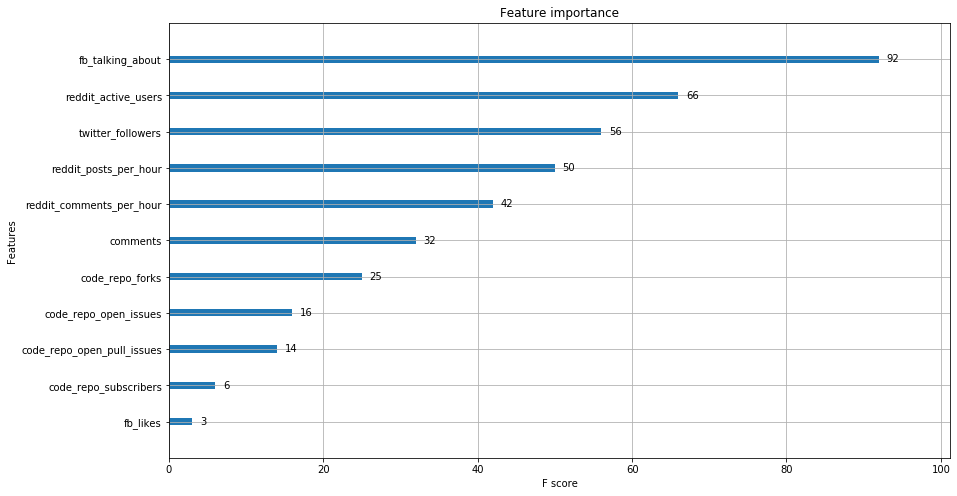

F1 0.9718; AUC 0.9943 
Model is predicting  [0. 1.] class
Accuracy of classifier on test set: 0.973
10-fold cross validation average accuracy of clf: 0.973
Confusion Matrix for Classfier:
[[60  1]
 [ 1 11]]
Classification Report for Classfier:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98        61
         1.0       0.92      0.92      0.92        12

    accuracy                           0.97        73
   macro avg       0.95      0.95      0.95        73
weighted avg       0.97      0.97      0.97        73



In [66]:
# make a new column if date was identified as an anomaly
anomaly_dates_modeling = social_anomalies.iloc[:,0]
social['anomaly'] = np.where(social.index.isin(anomaly_dates_modeling), 1, 0)

# min-max standardization 
anomalies_classified = scale(social)
X1 = anomalies_classified.drop('anomaly', axis=1)
y1 = anomalies_classified['anomaly']
# shape of X and y
display(X1.shape)
display(y1.shape)

# feature selection: plot feature importance using built-in function  
# fit the model
model = XGBClassifier(random_state=123)
model.fit(X1, y1)
# plot feature importance
plt.rcParams["figure.figsize"] = (14, 8)
plot_importance(model)
plt.show()

# modeling
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=123, shuffle = True)

# this is the formula after you split the dataset
sm = SMOTE(random_state=123, sampling_strategy = 'minority')
x_train_res, y_train_res = sm.fit_sample(X_train, y_train)

# fit model no training data
clf = XGBClassifier(random_state=123)

clf.fit(x_train_res, y_train_res)

# make predictions for test data
y_pred = clf.predict(X_test)
predictions = [round(value) for value in y_pred]

#10-fold cross validation
kfold = model_selection.KFold(n_splits=10, random_state=123, shuffle = True)
scoring = 'accuracy'
results = model_selection.cross_val_score(clf, x_train_res, y_train_res, cv=kfold, scoring=scoring)

# average is the bias, and std dev is variance
f1_scores = model_selection.cross_val_score(clf, x_train_res, y_train_res, cv=kfold, scoring='f1')
roc_scores = model_selection.cross_val_score(clf, x_train_res, y_train_res, cv=kfold, scoring='roc_auc')

#calculate f1-score and AUC
clf_roc_auc = roc_auc_score(y_test, y_pred)

# average F1 and AUC through 10 fold cross-validation
print('F1 {:.4f}; AUC {:.4f} '.format(f1_scores.mean(),roc_scores.mean()))

# Is our model still predicting just one class?
print('Model is predicting ',np.unique( y_pred ),'class' )

print('Accuracy of classifier on test set: {:.3f}'.format(clf.score(X_test, y_test)))

print("10-fold cross validation average accuracy of clf: %.3f" % (results.mean()))

confusion_matrix_y = confusion_matrix(y_test, y_pred)
print('Confusion Matrix for Classfier:')
print(confusion_matrix_y)

print('Classification Report for Classfier:')
print(classification_report(y_test, y_pred))

## 3.4.2 Data statistics where anomaly = 1 and anomaly = 0

In [67]:
print('Where anomaly = 1:')
display(anomalies_classified[anomalies_classified['anomaly']==1].describe())
print('Where anomaly = 0:')
anomalies_classified[anomalies_classified['anomaly']==0].describe()

Where anomaly = 1:


,comments,posts,followers,points,overview_page_views,analysis_page_views,markets_page_views,charts_page_views,trades_page_views,forum_page_views,influence_page_views,total_page_views,fb_likes,fb_talking_about,twitter_followers,twitter_following,twitter_lists,twitter_favourites,twitter_statuses,reddit_subscribers,reddit_active_users,reddit_posts_per_hour,reddit_posts_per_day,reddit_comments_per_hour,reddit_comments_per_day,code_repo_stars,code_repo_forks,code_repo_subscribers,code_repo_open_pull_issues,code_repo_closed_pull_issues,code_repo_open_issues,code_repo_closed_issues,anomaly
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.0
mean,0.346726,0.367855,0.438524,0.368430,0.400112,0.415168,0.438287,0.393860,0.395487,0.365457,0.432291,0.393073,0.263271,0.470542,0.852744,0.084556,0.902315,0.413657,0.945490,0.413744,0.382647,0.496701,0.496579,0.378427,0.378421,0.411334,0.426767,0.459388,0.380637,0.323075,0.488782,0.343253,1.0
std,0.402401,0.403919,0.349492,0.394692,0.395209,0.396807,0.386849,0.407550,0.407314,0.407425,0.400114,0.399820,0.270883,0.267770,0.182547,0.143604,0.149205,0.430148,0.141841,0.377552,0.242732,0.295138,0.295115,0.261578,0.261577,0.392900,0.398517,0.394177,0.220465,0.402642,0.233711,0.403827,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005328,0.003717,0.003748,0.032539,0.032537,0.000000,0.000000,0.000000,0.023529,0.000000,0.019231,0.000000,1.0
25%,0.024891,0.035640,0.154275,0.047737,0.070954,0.082531,0.108820,0.048656,0.052595,0.031466,0.091544,0.059526,0.112309,0.259452,0.799613,0.027834,0.866084,0.078586,0.945458,0.110532,0.171026,0.217937,0.217876,0.121897,0.121894,0.092790,0.103430,0.140084,0.194118,0.015905,0.358974,0.022685,1.0
50%,0.073285,0.101907,0.268674,0.112827,0.155706,0.182068,0.223709,0.118622,0.135300,0.089902,0.198579,0.137134,0.171534,0.431947,0.856495,0.040486,0.905595,0.124110,0.953142,0.201707,0.384073,0.503717,0.503663,0.389645,0.389641,0.185221,0.193227,0.253165,0.435294,0.038978,0.407051,0.070627,1.0
75%,0.855368,0.881443,0.826381,0.861840,0.897386,0.919822,0.919843,0.904872,0.914039,0.881649,0.938587,0.896954,0.304039,0.652647,1.000000,0.129555,1.000000,1.000000,1.000000,0.889584,0.517275,0.771190,0.770960,0.498184,0.498182,0.917676,0.951504,0.980591,0.494118,0.828629,0.653846,0.852666,1.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.800000,1.000000,1.000000,1.000000,1.0


Where anomaly = 0:


,comments,posts,followers,points,overview_page_views,analysis_page_views,markets_page_views,charts_page_views,trades_page_views,forum_page_views,influence_page_views,total_page_views,fb_likes,fb_talking_about,twitter_followers,twitter_following,twitter_lists,twitter_favourites,twitter_statuses,reddit_subscribers,reddit_active_users,reddit_posts_per_hour,reddit_posts_per_day,reddit_comments_per_hour,reddit_comments_per_day,code_repo_stars,code_repo_forks,code_repo_subscribers,code_repo_open_pull_issues,code_repo_closed_pull_issues,code_repo_open_issues,code_repo_closed_issues,anomaly
count,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.000000,317.0
mean,0.585089,0.634534,0.701955,0.621894,0.697079,0.715715,0.752135,0.732780,0.706964,0.646256,0.764402,0.695531,0.294143,0.277030,0.985593,0.111713,0.990370,0.816268,0.990853,0.660082,0.228082,0.245819,0.245703,0.169198,0.169193,0.684669,0.718415,0.779230,0.419670,0.527088,0.388559,0.572197,0.0
std,0.248723,0.231594,0.159604,0.228611,0.207402,0.208578,0.178676,0.193712,0.213811,0.233765,0.190056,0.209120,0.026665,0.083524,0.029191,0.030236,0.019143,0.305415,0.015485,0.215435,0.099666,0.108389,0.108390,0.122199,0.122199,0.220523,0.216580,0.196729,0.214524,0.274434,0.244152,0.258608,0.0
min,0.079726,0.109825,0.276957,0.120132,0.163656,0.189940,0.233922,0.128555,0.143542,0.096930,0.208499,0.145343,0.175491,0.115312,0.867707,0.040486,0.911929,0.126144,0.953572,0.209551,0.000000,0.000000,0.000000,0.000000,0.000000,0.193490,0.201125,0.264979,0.000000,0.040323,0.000000,0.077643,0.0
25%,0.392784,0.471095,0.604752,0.454913,0.559083,0.568918,0.648215,0.629993,0.577198,0.481119,0.665797,0.559616,0.304039,0.223062,0.989169,0.103239,0.990198,0.611394,0.982988,0.479028,0.164517,0.169145,0.168907,0.089222,0.089214,0.524544,0.570378,0.643882,0.270588,0.309588,0.205128,0.397568,0.0
50%,0.589409,0.644734,0.713917,0.629698,0.734876,0.754968,0.787721,0.785449,0.740806,0.678740,0.810429,0.734969,0.304039,0.268431,1.000000,0.129555,1.000000,1.000000,1.000000,0.685745,0.221399,0.246840,0.246755,0.141693,0.141695,0.715690,0.759818,0.827004,0.388235,0.511649,0.339744,0.566885,0.0
75%,0.814288,0.845747,0.800913,0.825180,0.869920,0.894600,0.890372,0.886164,0.889777,0.848590,0.916625,0.870034,0.304039,0.315690,1.000000,0.129555,1.000000,1.000000,1.000000,0.828642,0.287614,0.308922,0.308990,0.217055,0.217048,0.872266,0.913773,0.945992,0.552941,0.769713,0.596154,0.780168,0.0
max,0.992471,0.993631,0.990378,0.992644,0.993304,0.996710,0.995775,0.974543,0.995115,0.993075,0.997101,0.989841,0.306496,0.788280,1.000000,0.129555,1.000000,1.000000,1.000000,0.997438,0.586004,0.566171,0.565983,0.748796,0.748796,0.996159,0.995564,1.000000,1.000000,0.987903,0.955128,0.994387,0.0


### 3.5 Borderline probability analysis
e.g. the probability was 51% that date is an anomaly --> whats the realtionships

In [68]:
block_proba_s[0][:10]

array([[4.50292904e-03, 9.95497071e-01],
       [1.12099410e-03, 9.98879006e-01],
       [5.23235301e-03, 9.94767647e-01],
       [7.57957939e-04, 9.99242042e-01],
       [1.78144570e-04, 9.99821855e-01],
       [6.24011819e-03, 9.93759882e-01],
       [2.34677593e-03, 9.97653224e-01],
       [1.40997280e-02, 9.85900272e-01],
       [8.00851819e-04, 9.99199148e-01],
       [1.54262402e-01, 8.45737598e-01]])

## 4.1 Same anomalies identified all 3 datasets
- inner join (merge) anomaly likelihood dataframes for all three datasets 
- we get dates that were identified in all three datasets

In [69]:
# merge 3 dataframes on date 
three_dataset_anomalies = pd.merge(pd.merge(price_anomalies,block_anomalies,on='Date'),social_anomalies,on='Date')
# rename the columns so its easier to read/refer
three_dataset_anomalies.columns = ['Date', 'AllContaminations_Vote_Price', 'ModelAnomaly_Vote_Price',
       'weight_anomaly_models_Price', 'AllContaminations_Vote_Block',
       'ModelAnomaly_Vote_Block', 'weight_anomaly_models_Block',
       'AllContaminations_Vote_Social', 'ModelAnomaly_Vote_Social', 'weight_anomaly_models_Social']

# sum row-wise per date (for 3-datasets): mean contamination, sum and mean model votes
contamination_avg = pd.DataFrame(three_dataset_anomalies[['AllContaminations_Vote_Price','AllContaminations_Vote_Block',
                                      'AllContaminations_Vote_Social']].mean(axis=1))
modelVote_sum = pd.DataFrame(three_dataset_anomalies[['ModelAnomaly_Vote_Price','ModelAnomaly_Vote_Block',
                                      'ModelAnomaly_Vote_Social']].sum(axis=1))
modelVote_avg = pd.DataFrame(three_dataset_anomalies[['ModelAnomaly_Vote_Price','ModelAnomaly_Vote_Block',
                                      'ModelAnomaly_Vote_Social']].mean(axis=1))

# concat these 3 calculations, rename columns respectively, and sort it descending
three_dataset_anomalies_calc = pd.concat([contamination_avg,modelVote_sum,modelVote_avg],axis = 1)
three_dataset_anomalies_calc.columns = ['contamination_avg','modelVote_sum','modelVote_avg']
three_dataset_anomalies_calc = three_dataset_anomalies_calc.set_index(three_dataset_anomalies.Date)
three_dataset_anomalies_calc = three_dataset_anomalies_calc.sort_values(by=['contamination_avg','modelVote_sum']
                                                                            ,ascending = (False, False))

print('Nbr of common date anomalies across three datasets: ', len(three_dataset_anomalies.Date))
three_dataset_anomalies_calc

Nbr of common date anomalies across three datasets:  20


,contamination_avg,modelVote_sum,modelVote_avg
Date,,,
2018-01-05,5.000000,88,29.333333
2018-01-16,5.000000,85,28.333333
2018-01-04,5.000000,83,27.666667
2018-01-06,5.000000,81,27.000000
2018-01-17,5.000000,78,26.000000
2018-01-03,5.000000,75,25.000000
2018-01-02,5.000000,72,24.000000
2018-01-07,5.000000,70,23.333333
2018-01-01,5.000000,65,21.666667


## 4.2 Anomalies that were identified in 2 Datasets 
- here we will only make lists of dates to plot later on close price
- there are 3 possible combinations
    1. Price, Blockchain
    2. Price, Social
    3. Blockchain, Social

In [70]:
price_block = list(set(list(price_anomalies.Date)) & set(list(block_anomalies.Date)))
price_social = list(set(list(price_anomalies.Date)) & set(list(social_anomalies.Date)))
block_social = list(set(list(block_anomalies.Date)) & set(list(social_anomalies.Date)))

### 4.3 Find corresponding close price for anomaly dates
- Find it for: same dates across 3 datasets(4.1), and combinations of 2 (4.2)

In [71]:
# insert a list of dates and get it back with close prices
def close_prices_anomalies(anomaly_dates):
    close_anomalies = [] # collects close price for anomolous dates
    # iterate over anomaly dates
    for dates in anomaly_dates:
        # get close price for date that mathces the anomaly date
        close_loc = price.loc[str(dates),'close']
        # append it to the list
        close_anomalies.append(close_loc)
    # make close prices and dates into a series and then concat them together
    close_anomalies = pd.Series(close_anomalies)
    dates1 = pd.Series(anomaly_dates) # put that in parameter
    
    close_anomalies_df = pd.concat([dates1,close_anomalies], axis = 1)
    close_anomalies_df.columns = ['Date','Close'] # rename columns
    # make Date the index (needed for plotting alter)
    close_anomalies_df = close_anomalies_df.set_index('Date') 
    # convert dates into datetime
    close_anomalies_df.index = pd.to_datetime(close_anomalies_df.index)
    return close_anomalies_df

In [72]:
# call the functions and save resutls in the variable
three_datasets_close = close_prices_anomalies(three_dataset_anomalies_calc.index)
price_block_close = close_prices_anomalies(price_block)
price_social_close = close_prices_anomalies(price_social)
block_social_close = close_prices_anomalies(block_social)

## 4.3.1. Predicting anomalies (only common dates) - XGBOOST

In [73]:
# merge 3 datasets 
merge_df = pd.concat([price.drop('anomaly',axis=1),block.drop('anomaly',axis=1),social.drop('anomaly',axis=1)],axis=1)
merge_df.shape

(365, 95)

(365, 95)

(365,)

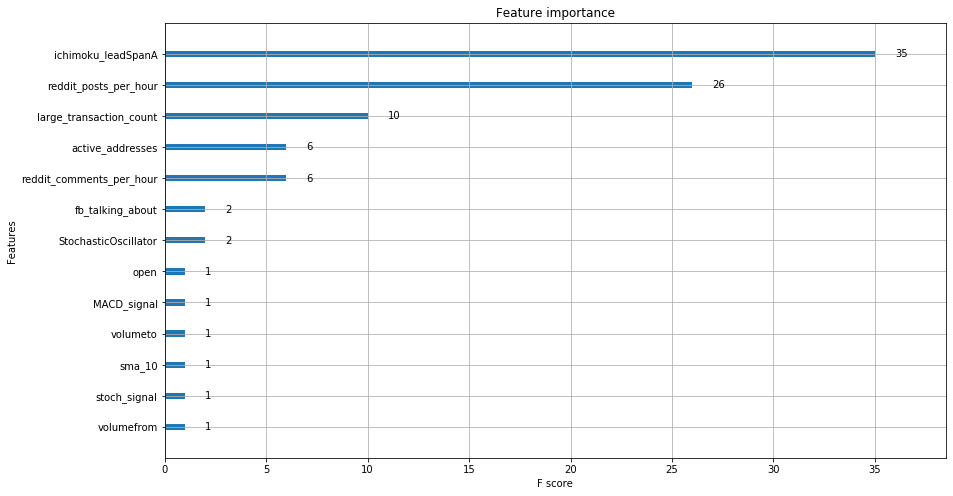

F1 0.9983; AUC 0.9981 
Model is predicting  [0. 1.] class
Accuracy of classifier on test set: 1.000
10-fold cross validation average accuracy of clf: 0.998
Confusion Matrix for Classfier:
[[68  0]
 [ 0  5]]
Classification Report for Classfier:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        68
         1.0       1.00      1.00      1.00         5

    accuracy                           1.00        73
   macro avg       1.00      1.00      1.00        73
weighted avg       1.00      1.00      1.00        73



In [74]:
# make a new column if date was identified as an anomaly
anomaly_dates_modeling = three_dataset_anomalies_calc.index
merge_df['anomaly'] = np.where(merge_df.index.isin(anomaly_dates_modeling), 1, 0)

# min-max standardization 
anomalies_classified = scale(merge_df)
X1 = anomalies_classified.drop('anomaly', axis=1)
y1 = anomalies_classified['anomaly']
# shape of X and y
display(X1.shape)
display(y1.shape)

# feature selection: plot feature importance using built-in function  
# fit the model
model = XGBClassifier(random_state=123)
model.fit(X1, y1)
# plot feature importance
plt.rcParams["figure.figsize"] = (14, 8)
plot_importance(model)
plt.show()

# modeling
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=123, shuffle = True)

# this is the formula after you split the dataset
sm = SMOTE(random_state=123, sampling_strategy = 'minority')
x_train_res, y_train_res = sm.fit_sample(X_train, y_train)

# fit model no training data
clf = XGBClassifier(random_state=123)

clf.fit(x_train_res, y_train_res)

# make predictions for test data
y_pred = clf.predict(X_test)
predictions = [round(value) for value in y_pred]

#10-fold cross validation
kfold = model_selection.KFold(n_splits=10, random_state=123, shuffle = True)
scoring = 'accuracy'
results = model_selection.cross_val_score(clf, x_train_res, y_train_res, cv=kfold, scoring=scoring)

# average is the bias, and std dev is variance
f1_scores = model_selection.cross_val_score(clf, x_train_res, y_train_res, cv=kfold, scoring='f1')
roc_scores = model_selection.cross_val_score(clf, x_train_res, y_train_res, cv=kfold, scoring='roc_auc')

#calculate f1-score and AUC
clf_roc_auc = roc_auc_score(y_test, y_pred)

# average F1 and AUC through 10 fold cross-validation
print('F1 {:.4f}; AUC {:.4f} '.format(f1_scores.mean(),roc_scores.mean()))

# Is our model still predicting just one class?
print('Model is predicting ',np.unique( y_pred ),'class' )

print('Accuracy of classifier on test set: {:.3f}'.format(clf.score(X_test, y_test)))

print("10-fold cross validation average accuracy of clf: %.3f" % (results.mean()))

confusion_matrix_y = confusion_matrix(y_test, y_pred)
print('Confusion Matrix for Classfier:')
print(confusion_matrix_y)

print('Classification Report for Classfier:')
print(classification_report(y_test, y_pred))

## 4.3.2 Data statistics where anomaly = 1 and anomaly = 0

In [75]:
print('Where anomaly = 1:')
display(anomalies_classified[anomalies_classified['anomaly']==1].describe())
print('Where anomaly = 0:')
anomalies_classified[anomalies_classified['anomaly']==0].describe()

Where anomaly = 1:


,close,high,low,open,volumefrom,volumeto,CCI,ichimoku_leadSpanA,ichimoku_leadSpanB,MACD,MACD_diff,MACD_signal,AwesomeOscillator,KAMA,RateofChange,RSI_7,RSI_14,StochasticOscillator,stoch_signal,TrueStrenghtIndex,UltimateOscilator,williamsR,Accum_Distrubution,ForceIndex,AvgTrueRange,BollingerHighBand,BHB_indicator,BollingerLowBand,BLB_indicator,BC_middleBand,BC_percBand,BCB_width,sma_5,sma_10,sma_20,sma_30,sma_50,sma_100,sma_200,ema_5,ema_10,ema_20,ema_30,ema_50,ema_100,ema_200,vwma,hull_Moving,Mkt_Cap,active_addresses,average_transaction_value,block_height,block_size,block_time,current_supply,difficulty,hashrate,large_transaction_count,new_addresses,transaction_count,transaction_count_all_time,unique_addresses_all_time,zero_balance_addresses_all_time,comments,posts,followers,points,overview_page_views,analysis_page_views,markets_page_views,charts_page_views,trades_page_views,forum_page_views,influence_page_views,total_page_views,fb_likes,fb_talking_about,twitter_followers,twitter_following,twitter_lists,twitter_favourites,twitter_statuses,reddit_subscribers,reddit_active_users,reddit_posts_per_hour,reddit_posts_per_day,reddit_comments_per_hour,reddit_comments_per_day,code_repo_stars,code_repo_forks,code_repo_subscribers,code_repo_open_pull_issues,code_repo_closed_pull_issues,code_repo_open_issues,code_repo_closed_issues,anomaly
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.0,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01,2.000000e+01,2.000000e+01,2.000000e+01,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.0
mean,0.764379,0.807790,0.747144,0.770358,0.259800,0.469785,0.599371,0.918438,0.925817,0.704624,0.449778,0.814561,0.615929,0.808296,0.315630,0.558602,0.574731,0.478989,0.482885,0.841542,0.841542,0.478989,0.350479,0.461608,0.334102,0.933366,0.0,0.891408,0.100000,0.928179,0.503204,0.434028,0.727313,0.624555,0.397496,3.592506e-01,3.843738e-01,3.637521e-01,4.323030e-01,0.875441,0.897461,0.909296,0.911959,0.911959,0.908022,0.902489,0.402339,0.592089,0.762811,0.799821,0.345588,0.029753,0.790411,0.177855,0.029754,0.022076,0.065798,0.699670,0.631075,0.626201,0.041479,0.049355,0.038357,0.023180,0.032762,0.126076,0.041770,0.062068,0.071343,0.093918,0.043495,0.048109,0.029602,0.079457,0.052661,0.090748,0.527410,0.793933,0.022368,0.856168,0.080061,0.942307,0.091437,0.477389,0.705279,0.705124,0.528779,0.528772,0.075221,0.083155,0.108228,0.226471,0.014449,0.389103,0.021609,1.0
std,0.134577,0.122695,0.144838,0.128738,0.156863,0.206484,0.139517,0.090883,0.079567,0.218225,0.302571,0.149431,0.186545,0.095000,0.132855,0.318143,0.306875,0.295159,0.293683,0.164258,0.164258,0.295159,0.142418,0.321874,0.467750,0.079093,0.0,0.101222,0.307794,0.051577,0.173818,0.169910,0.255113,0.311249,0.204499,5.695324e-17,5.695324e-17,5.695324e-17,1.139065e-16,0.088959,0.072959,0.064344,0.062539,0.062723,0.065774,0.069903,0.202998,0.273137,0.135276,0.109716,0.088619,0.019205,0.021899,0.091186,0.019205,0.026213,0.037131,0.170478,0.204847,0.193455,0.024815,0.029320,0.025094,0.017380,0.025122,0.076513,0.028757,0.041722,0.050632,0.060666,0.030510,0.035007,0.021821,0.053720,0.036039,0.052722,0.175959,0.040605,0.013176,0.031151,0.019657,0.007087,0.057679,0.182240,0.173837,0.173797,0.194770,0.194767,0

Where anomaly = 0:


,close,high,low,open,volumefrom,volumeto,CCI,ichimoku_leadSpanA,ichimoku_leadSpanB,MACD,MACD_diff,MACD_signal,AwesomeOscillator,KAMA,RateofChange,RSI_7,RSI_14,StochasticOscillator,stoch_signal,TrueStrenghtIndex,UltimateOscilator,williamsR,Accum_Distrubution,ForceIndex,AvgTrueRange,BollingerHighBand,BHB_indicator,BollingerLowBand,BLB_indicator,BC_middleBand,BC_percBand,BCB_width,sma_5,sma_10,sma_20,sma_30,sma_50,sma_100,sma_200,ema_5,ema_10,ema_20,ema_30,ema_50,ema_100,ema_200,vwma,hull_Moving,Mkt_Cap,active_addresses,average_transaction_value,block_height,block_size,block_time,current_supply,difficulty,hashrate,large_transaction_count,new_addresses,transaction_count,transaction_count_all_time,unique_addresses_all_time,zero_balance_addresses_all_time,comments,posts,followers,points,overview_page_views,analysis_page_views,markets_page_views,charts_page_views,trades_page_views,forum_page_views,influence_page_views,total_page_views,fb_likes,fb_talking_about,twitter_followers,twitter_following,twitter_lists,twitter_favourites,twitter_statuses,reddit_subscribers,reddit_active_users,reddit_posts_per_hour,reddit_posts_per_day,reddit_comments_per_hour,reddit_comments_per_day,code_repo_stars,code_repo_forks,code_repo_subscribers,code_repo_open_pull_issues,code_repo_closed_pull_issues,code_repo_open_issues,code_repo_closed_issues,anomaly
count,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.0
mean,0.283137,0.295092,0.289259,0.284844,0.152639,0.147910,0.610649,0.327763,0.302674,0.559376,0.511874,0.594005,0.637403,0.277531,0.367825,0.421594,0.381535,0.436608,0.430285,0.349035,0.349035,0.436608,0.772829,0.313516,0.291036,0.317604,0.026087,0.320750,0.066667,0.320757,0.532272,0.383900,0.305735,0.326916,0.366829,0.398288,0.445529,0.415940,0.446110,0.309876,0.308795,0.309988,0.307504,0.300184,0.284371,0.264484,0.372134,0.370623,0.286541,0.284417,0.217688,0.541213,0.565169,0.333857,0.541213,0.581546,0.500562,0.140212,0.200763,0.284408,0.508180,0.534084,0.546458,0.584500,0.632316,0.698688,0.620260,0.692574,0.711255,0.746626,0.725585,0.701823,0.642937,0.757902,0.690717,0.301639,0.289439,0.978221,0.113114,0.985898,0.802931,0.987355,0.658774,0.235134,0.254089,0.253975,0.177463,0.177458,0.681970,0.714665,0.773629,0.425439,0.528422,0.402471,0.572262,0.0
std,0.134790,0.140222,0.136142,0.135615,0.115925,0.125809,0.148483,0.161413,0.194108,0.160837,0.133947,0.187579,0.178249,0.141172,0.147122,0.177320,0.127209,0.297576,0.295635,0.121739,0.121739,0.297576,0.101798,0.036427,0.204830,0.181785,0.159625,0.145061,0.249806,0.161991,0.184964,0.211311,0.146226,0.157665,0.182316,0.185450,0.194256,0.202668,0.174720,0.149599,0.156316,0.164288,0.170113,0.176843,0.180371,0.179441,0.185327,0.176870,0.133883,0.125475,0.135578,0.273726,0.224094,0.161660,0.273724,0.281316,0.228720,0.076132,0.079351,0.126582,0.261635,0.260600,0.256617,0.261735,0.245745,0.173656,0.242162,0.222708,0.223111,0.195179,0.213226,0.229927,0.248463,0.207283,0.225065,0.090534,0.126177,0.074277,0.057312,0.057788,0.3191

## Plot Close price and annotate anomalies

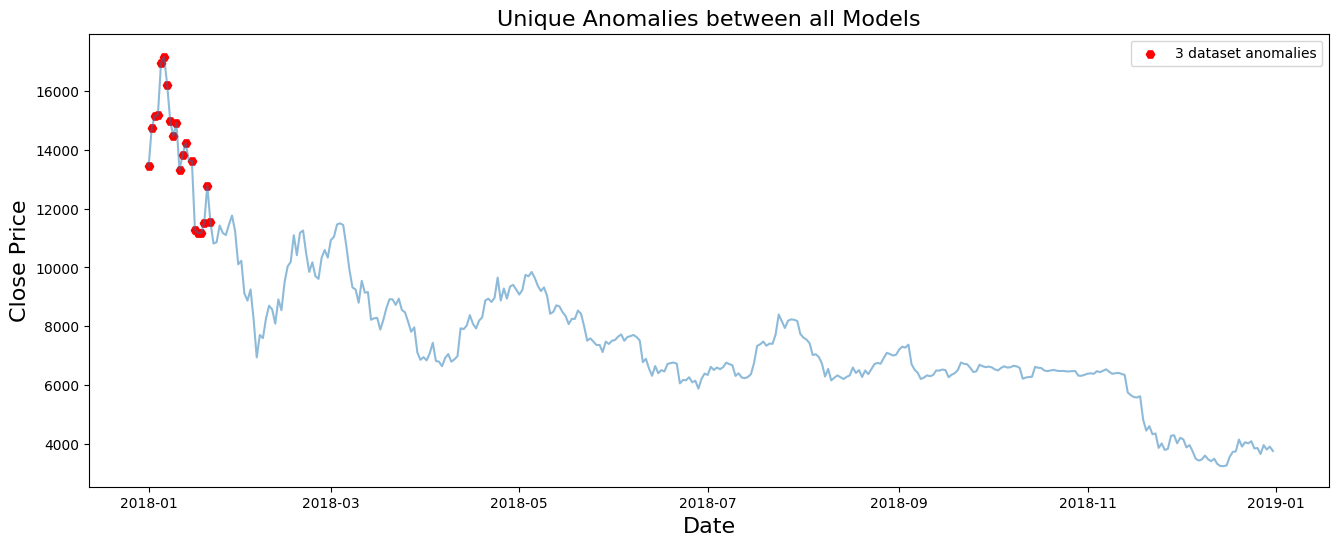

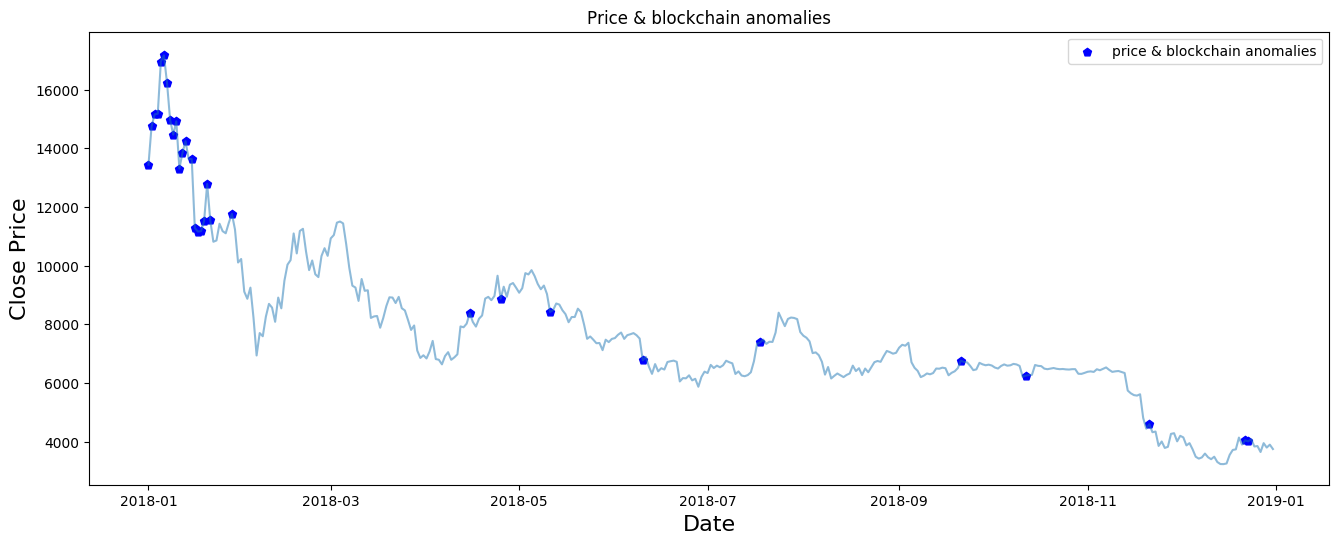

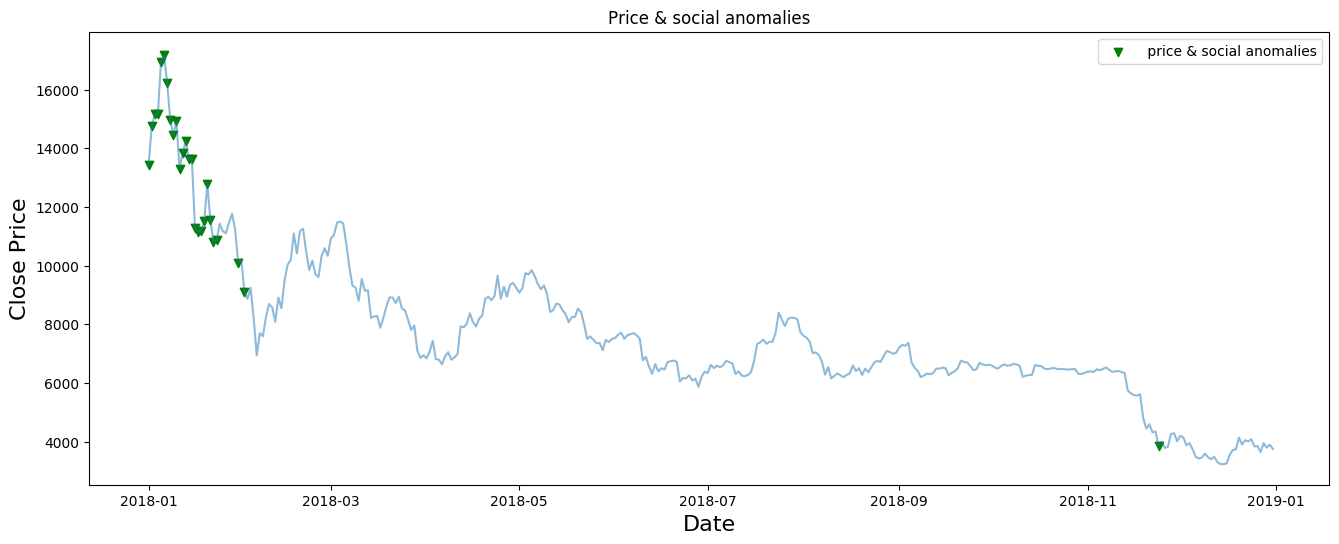

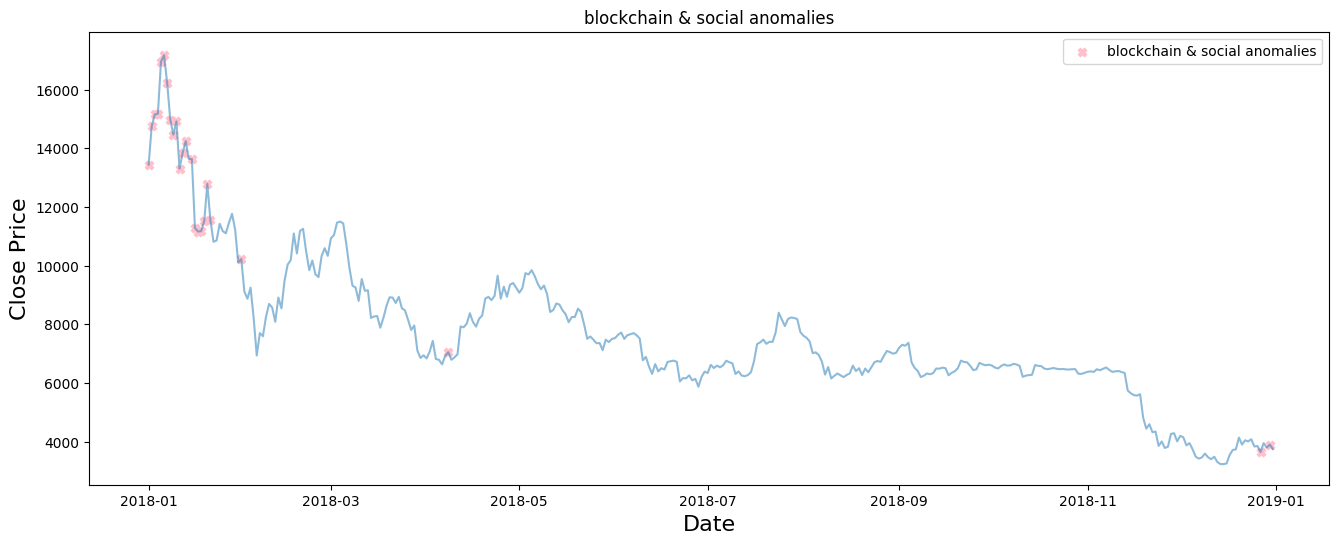

In [83]:
# filter for same dates 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt
# Converting the index as date
price.index = pd.to_datetime(price.index)
#common = \
#   set.intersection(set(price.index), set(three_datasets_close.index))
#filter1 = price[price.index.isin(common)]
#filter1 = filter1[['close']]

# Alter size for the plot
plt.subplots(dpi=100,figsize=(16,6))
# plot all close price data
plt.plot(price.index, price.close,  alpha=0.5)
# set x-axis label and specific size
plt.xlabel('Date',size=16)
# set y-axis label and specific size
plt.ylabel('Close Price',size=16)
# set plot title with specific size
plt.title('Unique Anomalies between all Models',size=16)

# plot anomalies 
plt.scatter(three_datasets_close.index, three_datasets_close.Close, color="red", marker = 'H',label='3 dataset anomalies')
plt.legend()
plt.show()

# Alter size for the plot
plt.subplots(dpi=100,figsize=(16,6))
# plot all close price data
plt.plot(price.index, price.close,  alpha=0.5)
# set x-axis label and specific size
plt.xlabel('Date',size=16)
# set y-axis label and specific size
plt.ylabel('Close Price',size=16)
plt.title('Price & blockchain anomalies')
plt.scatter(price_block_close.index, price_block_close.Close, color="blue", marker = 'p',label='price & blockchain anomalies')
plt.legend()
plt.show()

# Alter size for the plot
plt.subplots(dpi=100,figsize=(16,6))
# plot all close price data
plt.plot(price.index, price.close,  alpha=0.5)
# set x-axis label and specific size
plt.xlabel('Date',size=16)
# set y-axis label and specific size
plt.ylabel('Close Price',size=16)
plt.title('Price & social anomalies')
plt.scatter(price_social_close.index, price_social_close.Close, color="green", marker = 'v',label=' price & social anomalies')
plt.legend()
plt.show()

# Alter size for the plot
plt.subplots(dpi=100,figsize=(16,6))
# plot all close price data
plt.plot(price.index, price.close,  alpha=0.5)
# set x-axis label and specific size
plt.xlabel('Date',size=16)
# set y-axis label and specific size
plt.ylabel('Close Price',size=16)
plt.title('blockchain & social anomalies')
plt.scatter(block_social_close.index, block_social_close.Close, color="pink", marker = 'X',label='blockchain & social anomalies')
plt.legend()
plt.show()

# 5 Anomaly Detection on all 3 datasets together

In [90]:
# drop anomalies column 
X = anomalies_classified.drop('anomaly', axis = 1)
X.shape

(365, 95)

### 5.1 Run Models

In [91]:
# time the code
import time
t0 = time.time()

# empty list to store outliers and inliners
df_outliers = []
scores_pred_lst = []
proba_lst = []
predict_rank_lst = []

# iterate over different outlier fractions 
for fraction in outliers_fraction:
    classifiers = {#'AE' : AutoEncoder(contamination=outliers_fraction, random_state=random_state), # check why error
               'ABOD': ABOD(contamination = fraction),
              'CBLOF':CBLOF(check_estimator=False, random_state=random_state), # getting 0 
              'FB':FeatureBagging(LOF(n_neighbors=35),contamination=fraction,check_estimator=False,random_state=random_state),
              'HBOS': HBOS(contamination=fraction),
              'IF': IForest(contamination=fraction,random_state=random_state),
              'KNN': KNN(contamination=fraction),
              'Average KNN': KNN(method='mean',contamination=fraction),
              'OCSVM' : OCSVM(contamination=fraction),
              'SOS' : SOS(contamination=fraction),
              'LOF': LOF(n_neighbors=35, contamination = fraction),
              #'LOCI': LOCI(contamination = fraction), # takes a super long time + don't understand
              'VAE' : VAE(contamination=fraction, random_state=random_state) # default nbr of neurons too much for blockchain dataset
              }

    for i, (clf_name, clf) in enumerate(classifiers.items()):
        clf.fit(X)
        # predict raw anomaly score
        scores_pred = clf.decision_function(X) * -1 # WHY? * -1

        # prediction of a datapoint category outlier or inlier
        y_pred = clf.predict(X)

        # probability of outlier 
        probability = clf.predict_proba(X, method = 'linear')

        # predict rank
        predict_rank = clf._predict_rank(X)

        n_inliers = len(y_pred) - np.count_nonzero(y_pred)
        n_outliers = np.count_nonzero(y_pred == 1)

        # copy of dataframe
        dfx = X.copy()

        dfx[clf_name] = y_pred.tolist()
        #print(clf_name,'\n',i,clf,'\n',classifiers,'\n',classifiers.items())
        print('Outlier fraction: ', fraction)
        print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        #print('scores_pred: ', scores_pred)
        scores_pred_lst.append(scores_pred)
        df_outliers.append(dfx[clf_name]) 
        proba_lst.append(probability)
        predict_rank_lst.append(predict_rank)
t1 = time.time()
total = t1-t0

Outlier fraction:  0.01
OUTLIERS :  5 INLIERS :  360 ABOD
Outlier fraction:  0.01
OUTLIERS :  37 INLIERS :  328 CBLOF
Outlier fraction:  0.01
OUTLIERS :  3 INLIERS :  362 FB
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 HBOS
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 IF
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 KNN
Outlier fraction:  0.01
OUTLIERS :  2 INLIERS :  363 Average KNN
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 OCSVM
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 SOS
Outlier fraction:  0.01
OUTLIERS :  3 INLIERS :  362 LOF
Model: "model_91"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_61 (InputLayer)           (None, 95)           0                                            
__________________________________________________________________________________________________
den

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_92 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_92.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 167.8423 - val_loss: 149.4306
Epoch 2/100
328/328 [==============================] - 0s 108us/step - loss: 123.1656 - val_loss: 133.5914
Epoch 3/100
328/328 [==============================] - 0s 108us/step - loss: 113.7543 - val_loss: 122.5411
Epoch 4/100
328/328 [==============================] - 0s 107us/step - loss: 105.2626 - val_loss: 113.0564
Epoch 5/100
328/328 [==============================] - 0s 107us/step - loss: 98.2142 - val_loss: 106.8025
Epoch 6/100
328/328 [==============================] - 0s 114us/step - loss: 95.5744 - val_loss: 104.3770
Epoch 7/100
328/328 [==============================] - 0s 107us/step - loss: 94.9774 - val_loss: 104.1876
Epoch 8/100
328/328 [==============================] - 0s 108us/step - loss: 94.8462 - val_loss: 103.8669
Epoch 9/100
328/328 [==============================] - 0s 110us/step - loss: 94.7553 - val_loss: 103.8355

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_95 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_95.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 180.0523 - val_loss: 100.5717
Epoch 2/100
328/328 [==============================] - 0s 106us/step - loss: 127.6378 - val_loss: 85.2396
Epoch 3/100
328/328 [==============================] - 0s 108us/step - loss: 114.0684 - val_loss: 76.0924
Epoch 4/100
328/328 [==============================] - 0s 104us/step - loss: 104.2114 - val_loss: 69.0906
Epoch 5/100
328/328 [==============================] - 0s 108us/step - loss: 99.8537 - val_loss: 67.8507
Epoch 6/100
328/328 [==============================] - 0s 104us/step - loss: 98.9481 - val_loss: 67.1138
Epoch 7/100
328/328 [==============================] - 0s 118us/step - loss: 98.6306 - val_loss: 67.2555
Epoch 8/100
328/328 [==============================] - 0s 104us/step - loss: 98.4204 - val_loss: 67.0758
Epoch 9/100
328/328 [==============================] - 0s 106us/step - loss: 98.3807 - val_loss: 67.0488
Epoch 1

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_98 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_98.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 181.4216 - val_loss: 137.5413
Epoch 2/100
328/328 [==============================] - 0s 104us/step - loss: 126.2954 - val_loss: 121.9218
Epoch 3/100
328/328 [==============================] - 0s 104us/step - loss: 113.2294 - val_loss: 111.8750
Epoch 4/100
328/328 [==============================] - 0s 124us/step - loss: 103.2101 - val_loss: 103.2115
Epoch 5/100
328/328 [==============================] - 0s 103us/step - loss: 97.3880 - val_loss: 98.8773
Epoch 6/100
328/328 [==============================] - 0s 102us/step - loss: 95.4813 - val_loss: 98.2338
Epoch 7/100
328/328 [==============================] - 0s 127us/step - loss: 95.0553 - val_loss: 98.2985
Epoch 8/100
328/328 [==============================] - 0s 103us/step - loss: 94.9128 - val_loss: 98.2450
Epoch 9/100
328/328 [==============================] - 0s 131us/step - loss: 94.8666 - val_loss: 98.1592
Epoc

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_101 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_101.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 212.7249 - val_loss: 99.0097
Epoch 2/100
328/328 [==============================] - 0s 108us/step - loss: 133.7472 - val_loss: 85.8848
Epoch 3/100
328/328 [==============================] - 0s 107us/step - loss: 120.2741 - val_loss: 78.2876
Epoch 4/100
328/328 [==============================] - 0s 108us/step - loss: 111.9563 - val_loss: 71.8717
Epoch 5/100
328/328 [==============================] - 0s 108us/step - loss: 104.4085 - val_loss: 64.8177
Epoch 6/100
328/328 [==============================] - 0s 105us/step - loss: 100.7840 - val_loss: 63.4807
Epoch 7/100
328/328 [==============================] - 0s 105us/step - loss: 99.4494 - val_loss: 62.5482
Epoch 8/100
328/328 [==============================] - 0s 107us/step - loss: 99.0860 - val_loss: 62.5744
Epoch 9/100
328/328 [==============================] - 0s 108us/step - loss: 98.8867 - val_loss: 62.6378
Epoch 

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_104 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_104.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 176.0069 - val_loss: 123.2519
Epoch 2/100
328/328 [==============================] - 0s 105us/step - loss: 127.6029 - val_loss: 109.7892
Epoch 3/100
328/328 [==============================] - 0s 107us/step - loss: 114.6788 - val_loss: 101.6526
Epoch 4/100
328/328 [==============================] - 0s 108us/step - loss: 107.3044 - val_loss: 96.2856
Epoch 5/100
328/328 [==============================] - 0s 111us/step - loss: 100.2663 - val_loss: 91.2861
Epoch 6/100
328/328 [==============================] - 0s 107us/step - loss: 97.3118 - val_loss: 90.8499
Epoch 7/100
328/328 [==============================] - 0s 108us/step - loss: 96.1246 - val_loss: 90.8071
Epoch 8/100
328/328 [==============================] - 0s 109us/step - loss: 95.9929 - val_loss: 90.5242
Epoch 9/100
328/328 [==============================] - 0s 105us/step - loss: 95.7718 - val_loss: 90.6351
Epoc

In [92]:
print('Time to run: ',total,'s')
# we have 50 lists (or essentially 5 with 10 models)
print(len(df_outliers))

Time to run:  44.09610438346863 s
55


In [93]:
# save the outliers lists uniquely for later
allthree_df_s = df_outliers
# probability lists
allthree_proba_s = proba_lst
# rank lists
allthree_rank_s = predict_rank_lst

### 5.2 Seperate models per contamination

In [94]:
# unpack lists based on outlier fraction e.g. first 10 = 0.01 outlier fraction
frac_oo1 = df_outliers[0:11]
frac_oo2 = df_outliers[11:22]
frac_oo3 = df_outliers[22:33]
frac_oo4 = df_outliers[33:44]
frac_oo5 = df_outliers[44:]

# use the function to extract the dates
frac_oo1_outliers = outlier_subset_function(frac_oo1)
frac_oo2_outliers = outlier_subset_function(frac_oo2)
frac_oo3_outliers = outlier_subset_function(frac_oo3)
frac_oo4_outliers = outlier_subset_function(frac_oo4)
frac_oo5_outliers = outlier_subset_function(frac_oo5)

### 5.3 Get unique dates per anomaly contamination

In [95]:
dates_per_fraction(frac_oo1_outliers,frac_oo2_outliers,frac_oo3_outliers,frac_oo4_outliers,frac_oo5_outliers)

Outlier fraction 0.01 unique dates:  41
Outlier fraction 0.02 unique dates:  49
Outlier fraction 0.03 unique dates:  54
Outlier fraction 0.04 unique dates:  62
Outlier fraction 0.05 unique dates:  71


### 5.4 Anomaly likelihood

In [96]:
allthree_anomalies = date_ranking(frac_oo1_outliers,frac_oo2_outliers,frac_oo3_outliers,frac_oo4_outliers,frac_oo5_outliers)
print('Unique Anomaly Dates: ',len(allthree_anomalies.Date.unique()))
allthree_anomalies

Unique Anomaly Dates:  71


,Date,AllContaminations_Vote,ModelAnomaly_Vote,weight_anomaly_models
17,2018-04-08,5,40,0.057803
9,2018-01-06,5,33,0.047688
11,2018-01-16,5,32,0.046243
18,2018-01-01,5,32,0.046243
1,2018-01-05,5,29,0.041908
34,2018-01-17,5,28,0.040462
0,2018-01-02,5,26,0.037572
31,2018-01-04,5,26,0.037572
27,2018-01-07,5,25,0.036127
2,2018-01-03,5,24,0.034682


## 5.4.1. Predicting anomalies - XGBOOST (only common dates)

(365, 95)

(365,)

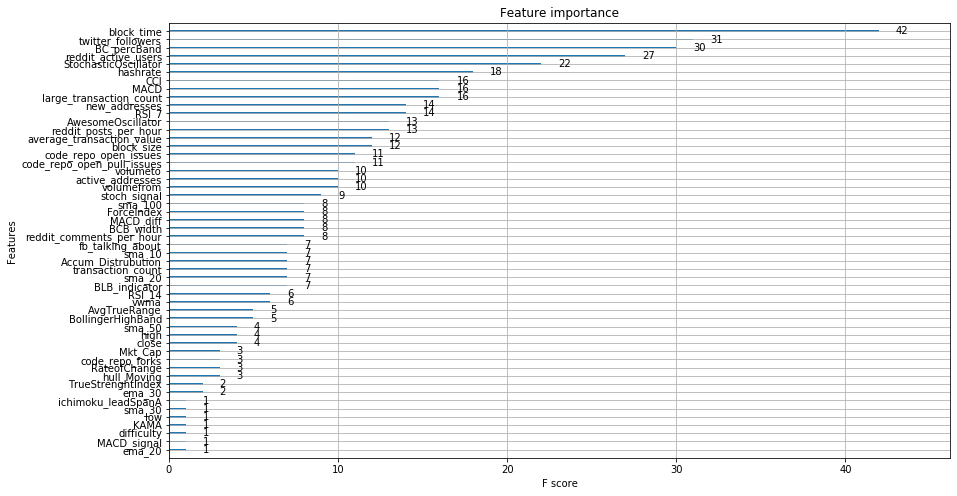

F1 0.9294; AUC 0.9777 
Model is predicting  [0 1] class
Accuracy of classifier on test set: 0.781
10-fold cross validation average accuracy of clf: 0.931
Confusion Matrix for Classfier:
[[49  5]
 [11  8]]
Classification Report for Classfier:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86        54
           1       0.62      0.42      0.50        19

    accuracy                           0.78        73
   macro avg       0.72      0.66      0.68        73
weighted avg       0.76      0.78      0.77        73



In [109]:
# make a new column if date was identified as an anomaly
anomaly_dates_modeling = allthree_anomalies.Date
X['anomaly'] = np.where(X.index.isin(anomaly_dates_modeling), 1, 0)

# min-max standardization 
X1 = X.drop('anomaly', axis=1)
y1 = X['anomaly']
# shape of X and y
display(X1.shape)
display(y1.shape)

# feature selection: plot feature importance using built-in function  
# fit the model
model = XGBClassifier(random_state=123)
model.fit(X1, y1)
# plot feature importance
plt.rcParams["figure.figsize"] = (14, 8)
plot_importance(model)
plt.show()

# modeling
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=123, shuffle = True)

# this is the formula after you split the dataset
sm = SMOTE(random_state=123, sampling_strategy = 'minority')
x_train_res, y_train_res = sm.fit_sample(X_train, y_train)

# fit model no training data
clf = XGBClassifier(random_state=123)

clf.fit(x_train_res, y_train_res)

# make predictions for test data
y_pred = clf.predict(X_test)
predictions = [round(value) for value in y_pred]

#10-fold cross validation
kfold = model_selection.KFold(n_splits=10, random_state=123, shuffle = True)
scoring = 'accuracy'
results = model_selection.cross_val_score(clf, x_train_res, y_train_res, cv=kfold, scoring=scoring)

# average is the bias, and std dev is variance
f1_scores = model_selection.cross_val_score(clf, x_train_res, y_train_res, cv=kfold, scoring='f1')
roc_scores = model_selection.cross_val_score(clf, x_train_res, y_train_res, cv=kfold, scoring='roc_auc')

#calculate f1-score and AUC
clf_roc_auc = roc_auc_score(y_test, y_pred)

# average F1 and AUC through 10 fold cross-validation
print('F1 {:.4f}; AUC {:.4f} '.format(f1_scores.mean(),roc_scores.mean()))

# Is our model still predicting just one class?
print('Model is predicting ',np.unique( y_pred ),'class' )

print('Accuracy of classifier on test set: {:.3f}'.format(clf.score(X_test, y_test)))

print("10-fold cross validation average accuracy of clf: %.3f" % (results.mean()))

confusion_matrix_y = confusion_matrix(y_test, y_pred)
print('Confusion Matrix for Classfier:')
print(confusion_matrix_y)

print('Classification Report for Classfier:')
print(classification_report(y_test, y_pred))

## 5.4.2 Data statistics where anomaly = 1 and anomaly = 0
- all features used

In [113]:
print('Where anomaly = 1:')
display(X[X['anomaly']==1].describe())
print('Where anomaly = 0:')
X[X['anomaly']==0].describe()

Where anomaly = 1:


,close,high,low,open,volumefrom,volumeto,CCI,ichimoku_leadSpanA,ichimoku_leadSpanB,MACD,MACD_diff,MACD_signal,AwesomeOscillator,KAMA,RateofChange,RSI_7,RSI_14,StochasticOscillator,stoch_signal,TrueStrenghtIndex,UltimateOscilator,williamsR,Accum_Distrubution,ForceIndex,AvgTrueRange,BollingerHighBand,BHB_indicator,BollingerLowBand,BLB_indicator,BC_middleBand,BC_percBand,BCB_width,sma_5,sma_10,sma_20,sma_30,sma_50,sma_100,sma_200,ema_5,ema_10,ema_20,ema_30,ema_50,ema_100,ema_200,vwma,hull_Moving,Mkt_Cap,active_addresses,average_transaction_value,block_height,block_size,block_time,current_supply,difficulty,hashrate,large_transaction_count,new_addresses,transaction_count,transaction_count_all_time,unique_addresses_all_time,zero_balance_addresses_all_time,comments,posts,followers,points,overview_page_views,analysis_page_views,markets_page_views,charts_page_views,trades_page_views,forum_page_views,influence_page_views,total_page_views,fb_likes,fb_talking_about,twitter_followers,twitter_following,twitter_lists,twitter_favourites,twitter_statuses,reddit_subscribers,reddit_active_users,reddit_posts_per_hour,reddit_posts_per_day,reddit_comments_per_hour,reddit_comments_per_day,code_repo_stars,code_repo_forks,code_repo_subscribers,code_repo_open_pull_issues,code_repo_closed_pull_issues,code_repo_open_issues,code_repo_closed_issues,anomaly
count,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.0
mean,0.423869,0.452068,0.418547,0.432801,0.245480,0.297160,0.553283,0.519745,0.523399,0.559076,0.465831,0.619719,0.585777,0.449114,0.330236,0.402161,0.394072,0.396126,0.403625,0.485232,0.485232,0.396126,0.628210,0.339475,0.357820,0.527526,0.042254,0.500447,0.295775,0.521329,0.463197,0.422645,0.439914,0.437006,0.400316,0.425011,0.422211,0.361067,0.431541,0.491183,0.503173,0.512765,0.513379,0.508584,0.495921,0.480559,0.402511,0.442158,0.425216,0.464418,0.284135,0.369268,0.682371,0.288406,0.369268,0.394267,0.351448,0.313045,0.328054,0.393388,0.355228,0.374451,0.377371,0.393721,0.427870,0.506000,0.423647,0.472550,0.490356,0.521806,0.483819,0.473183,0.428832,0.521035,0.467455,0.223553,0.354722,0.894232,0.089668,0.929860,0.507329,0.958365,0.468557,0.351955,0.418991,0.418874,0.345890,0.345884,0.473567,0.495342,0.543840,0.396852,0.353217,0.438877,0.382851,1.0
std,0.258789,0.268231,0.253541,0.257805,0.178296,0.217370,0.199899,0.305792,0.334177,0.227033,0.220012,0.241423,0.217580,0.273938,0.190693,0.278010,0.240098,0.331581,0.317423,0.269002,0.269002,0.331581,0.222415,0.192712,0.336269,0.321104,0.202599,0.288520,0.459639,0.306496,0.237116,0.214487,0.263995,0.255369,0.202831,0.204949,0.170647,0.131154,0.134434,0.287289,0.298283,0.306807,0.312425,0.319866,0.327698,0.333479,0.204601,0.236818,0.256644,0.253589,0.157869,0.348155,0.205778,0.181207,0.348153,0.370001,0.293869,0.271678,0.232748,0.215624,0.325901,0.330957,0.336113,0.354766,0.357582,0.308075,0.348162,0.353621,0.357294,0.346825,0.366403,0.366371,0.363540,0.362488,0.357715,0.097251,0.176835,0.161404,0.119569,0.128700,0.428493,0.118158,0.334583,0.199961,0.252485,0.252469,0.243357,0.243356,0.352731,0.357804,0.360570,0.2

Where anomaly = 0:


,close,high,low,open,volumefrom,volumeto,CCI,ichimoku_leadSpanA,ichimoku_leadSpanB,MACD,MACD_diff,MACD_signal,AwesomeOscillator,KAMA,RateofChange,RSI_7,RSI_14,StochasticOscillator,stoch_signal,TrueStrenghtIndex,UltimateOscilator,williamsR,Accum_Distrubution,ForceIndex,AvgTrueRange,BollingerHighBand,BHB_indicator,BollingerLowBand,BLB_indicator,BC_middleBand,BC_percBand,BCB_width,sma_5,sma_10,sma_20,sma_30,sma_50,sma_100,sma_200,ema_5,ema_10,ema_20,ema_30,ema_50,ema_100,ema_200,vwma,hull_Moving,Mkt_Cap,active_addresses,average_transaction_value,block_height,block_size,block_time,current_supply,difficulty,hashrate,large_transaction_count,new_addresses,transaction_count,transaction_count_all_time,unique_addresses_all_time,zero_balance_addresses_all_time,comments,posts,followers,points,overview_page_views,analysis_page_views,markets_page_views,charts_page_views,trades_page_views,forum_page_views,influence_page_views,total_page_views,fb_likes,fb_talking_about,twitter_followers,twitter_following,twitter_lists,twitter_favourites,twitter_statuses,reddit_subscribers,reddit_active_users,reddit_posts_per_hour,reddit_posts_per_day,reddit_comments_per_hour,reddit_comments_per_day,code_repo_stars,code_repo_forks,code_repo_subscribers,code_repo_open_pull_issues,code_repo_closed_pull_issues,code_repo_open_issues,code_repo_closed_issues,anomaly
count,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.0
mean,0.281888,0.292060,0.289185,0.282141,0.137509,0.133763,0.623735,0.321582,0.291760,0.569330,0.518769,0.602799,0.648410,0.272201,0.373352,0.435607,0.391650,0.449268,0.440302,0.349647,0.349647,0.449268,0.779023,0.317321,0.277838,0.308797,0.020408,0.316174,0.013605,0.313641,0.546976,0.377954,0.302009,0.320577,0.360828,0.389178,0.447000,0.425641,0.448690,0.304565,0.301899,0.301787,0.298906,0.291474,0.275708,0.255704,0.366852,0.368413,0.285451,0.276009,0.210342,0.547944,0.552188,0.334221,0.547944,0.588715,0.506996,0.136532,0.199295,0.281340,0.513369,0.539660,0.552727,0.592388,0.640904,0.706269,0.628388,0.702818,0.721069,0.756518,0.737570,0.712568,0.652919,0.768952,0.701229,0.306150,0.289862,0.985967,0.112603,0.990606,0.825143,0.991292,0.666117,0.223402,0.244959,0.244842,0.160687,0.160682,0.691023,0.724670,0.783857,0.418808,0.535769,0.392770,0.580544,0.0
std,0.132336,0.137238,0.134255,0.132540,0.090798,0.107390,0.128995,0.153722,0.180409,0.149953,0.123040,0.178651,0.165872,0.134620,0.132975,0.161264,0.117219,0.287945,0.289914,0.117998,0.117998,0.287945,0.093451,0.026886,0.187888,0.172323,0.141633,0.140945,0.116044,0.154674,0.165462,0.207553,0.142930,0.151515,0.177945,0.173754,0.193566,0.208509,0.177420,0.144604,0.149088,0.154770,0.159701,0.165757,0.168673,0.167170,0.181125,0.173984,0.131596,0.118793,0.126998,0.263969,0.220997,0.156645,0.263967,0.270309,0.219884,0.071894,0.076698,0.123361,0.253386,0.251899,0.247023,0.251009,0.233944,0.162594,0.230983,0.209212,0.210098,0.181552,0.197016,0.215561,0.235384,0.192201,0.211151,0.095298,0.126733,0.030152,0.029675,0.019799,0.2996

### 5.5 Borderline probability analysis

In [114]:
allthree_proba_s[0][:10]

array([[4.03208341e-04, 9.99596792e-01],
       [3.44879937e-03, 9.96551201e-01],
       [1.79113641e-02, 9.82088636e-01],
       [5.98103490e-03, 9.94018965e-01],
       [2.70745040e-03, 9.97292550e-01],
       [1.62647169e-03, 9.98373528e-01],
       [1.31880221e-02, 9.86811978e-01],
       [5.48687835e-03, 9.94513122e-01],
       [4.57138893e-03, 9.95428611e-01],
       [6.37301930e-03, 9.93626981e-01]])

In [115]:
allthree_datasets_close = close_prices_anomalies(allthree_anomalies.Date)

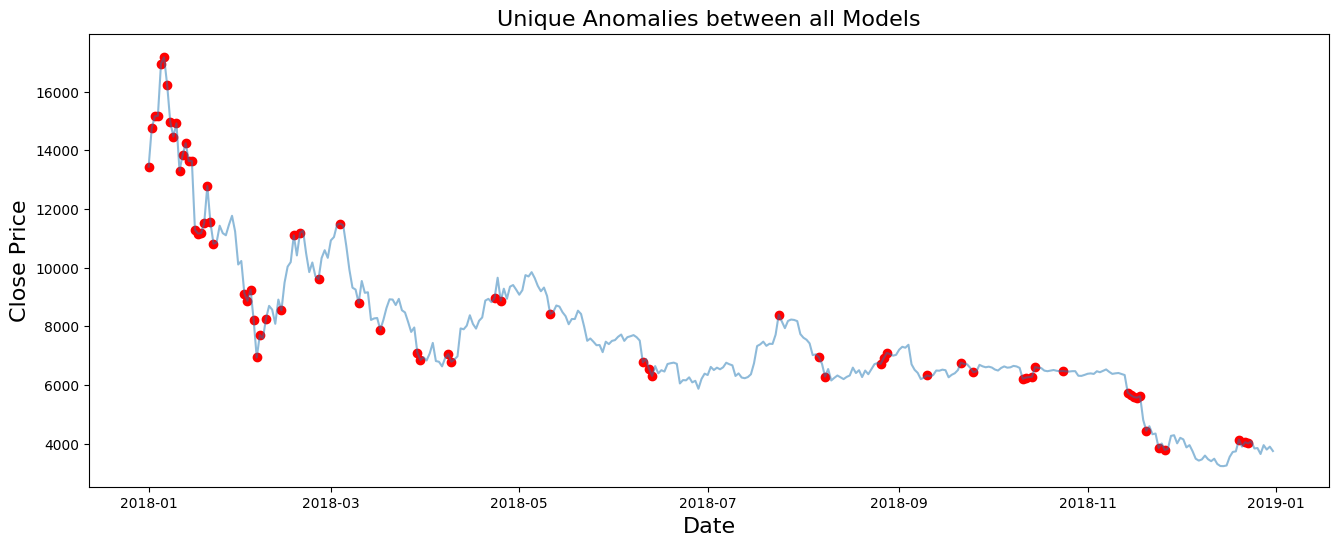

In [116]:
# Converting the index as date
price.index = pd.to_datetime(price.index)
# link close price to anomolous dates
common = \
   set.intersection(set(price.index), set(allthree_datasets_close.index))
filter1 = price[price.index.isin(common)]
filter1 = filter1[['close']]

# plot price
# Alter size for the plot
plt.subplots(dpi=100,figsize=(16,6))
# plot all close price data
plt.plot(price.index, price.close,  alpha=0.5)
# set x-axis label and specific size
plt.xlabel('Date',size=16)
# set y-axis label and specific size
plt.ylabel('Close Price',size=16)
# set plot title with specific size
plt.title('Unique Anomalies between all Models',size=16)

# plot anomalies 
plt.scatter(filter1.index, filter1.close, color="red")
plt.show()

## 6 Leave-one-out

In [117]:
# slice into 365 - 1
# test with 1 model 
for idx, row in X.drop('anomaly',axis=1).iterrows(): # that row is the thing to test
    # remainder user for training, remove row from dataframe and that row becomes your testing in that round
    X_pred = 0
    X_test = row
    X_train = X.drop(idx,axis=0)
    
    #clf = IForest(contamination=0.05,random_state=123)
    clf = KNN(method='mean',contamination=0.03)
    clf.fit(X_train)
    
    X_test = X_test.values.reshape(1,-1)
    
    X_pred = clf.predict(X_test)
    print(X_pred)
    # save everything after each round

ValueError: query data dimension must match training data dimension

## Practice code

In [62]:
# getting all close price values 
close_anomalies = []
for dates in allthree_anomalies['Date']:
    # get close price 
    d = X.loc[str(dates),'close']
    close_anomalies.append(d)
close_anomalies = pd.Series(close_anomalies)
table_dates = allthree_anomalies['Date']
anomalies = pd.concat([table_dates,close_anomalies], axis = 1)
anomalies.columns = ['Date','Close']
anomalies.Date = pd.to_datetime(anomalies.Date)

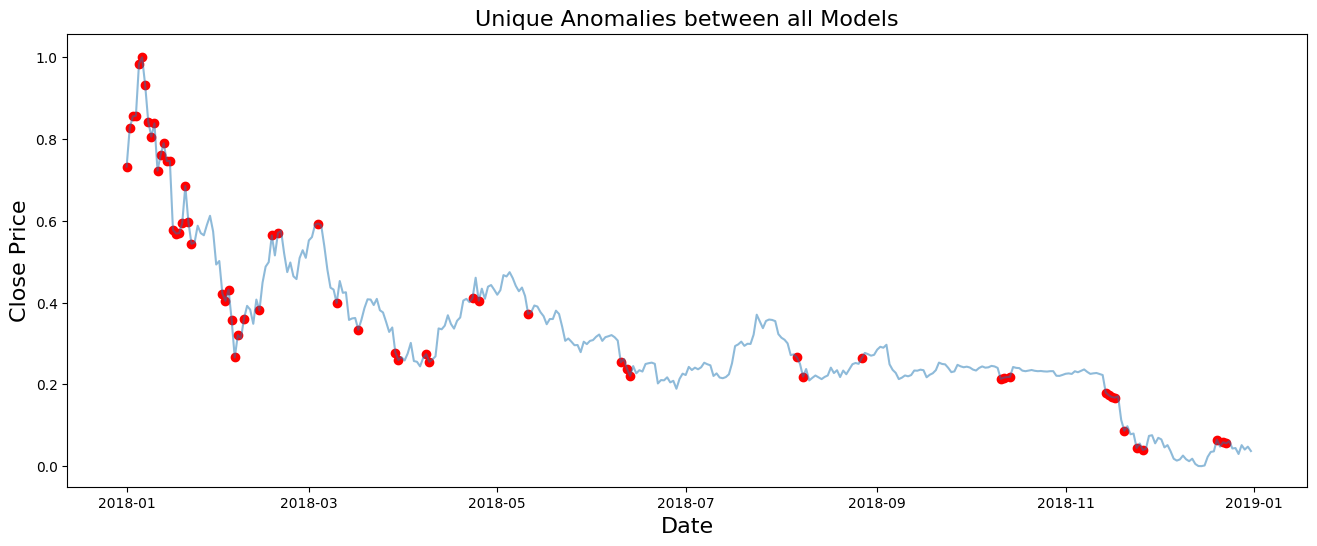

In [68]:
# filter for same dates 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt
common = \
    set.intersection(set(X.index), set(anomalies.Date))
filter1 = X[X.index.isin(common)]
filter1 = filter1[['close']]

# Converting the index as date
X.index = pd.to_datetime(X.index)
# Alter size for the plot
plt.subplots(dpi=100,figsize=(16,6))
# plot all close price data
plt.plot(X.index, X.close,  alpha=0.5)
# set x-axis label and specific size
plt.xlabel('Date',size=16)
# set y-axis label and specific size
plt.ylabel('Close Price',size=16)
# set plot title with specific size
plt.title('Unique Anomalies between all Models',size=16)

# plot anomalies 
plt.scatter(filter1.index, filter1.close, color="red")
plt.show()

In [73]:
def close_prices_anomalies(anomaly_df, main_df):
    # getting all close price values 
    close_anomalies = []
    for dates in anomaly_df['Date']:
        # get close price 
        d = main_df.loc[str(dates),'close']
        close_anomalies.append(d)
    close_anomalies = pd.Series(close_anomalies)
    table_dates = allthree_anomalies['Date']
    anomalies = pd.concat([table_dates,close_anomalies], axis = 1)
    anomalies.columns = ['Date','Close']
    anomalies.Date = pd.to_datetime(anomalies.Date)
    return anomalies 

In [70]:
def plot_anomalies(main_df, anomaly_df):
    common = \
    set.intersection(set(main_df.index), set(anomaly_df.Date))
    filter1 = main_df[main_df.index.isin(common)]
    filter1 = filter1[['close']]

    # Converting the index as date
    main_df.index = pd.to_datetime(main_df.index)
    # Alter size for the plot
    plt.subplots(dpi=100,figsize=(16,6))
    # plot all close price data
    plt.plot(main_df.index, main_df.close,  alpha=0.5)
    # set x-axis label and specific size
    plt.xlabel('Date',size=16)
    # set y-axis label and specific size
    plt.ylabel('Close Price',size=16)
    # set plot title with specific size
    plt.title('Unique Anomalies between all Models',size=16)

    # plot anomalies 
    plt.scatter(filter1.index, filter1.close, color="red")
    plt.show()

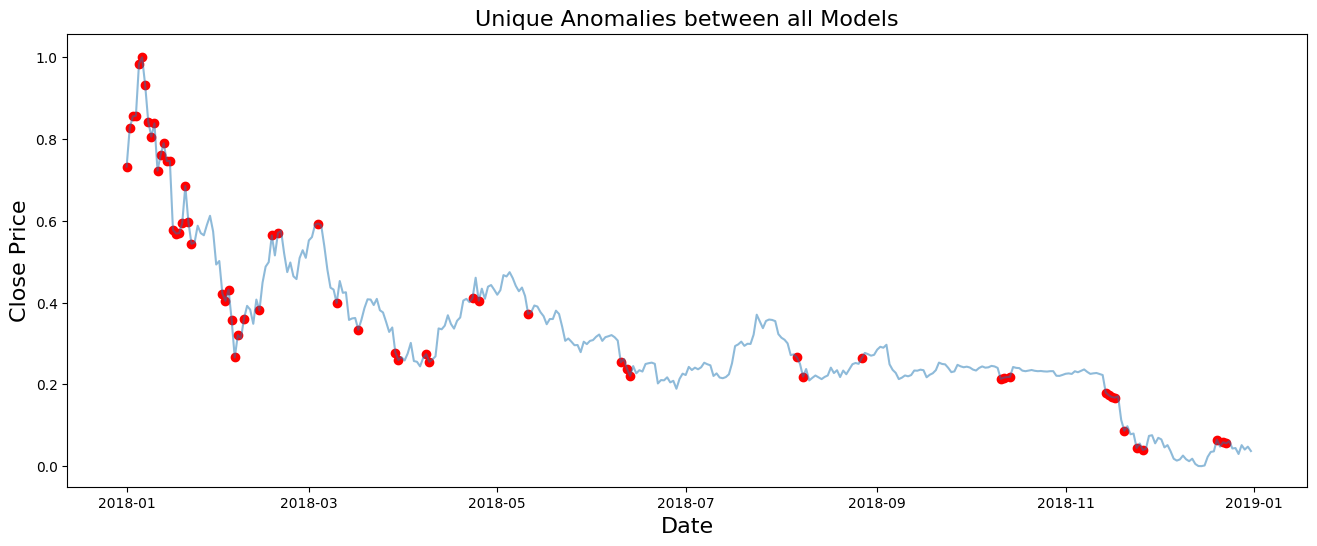

In [71]:
plot_anomalies(X,anomalies)

- it would be interesting to see if there are any "signals" for data identified as an anomaly right before price **spikes** or **drops**
- I would say major anomalies were flagged but some are still missing (visially) granted only 5 models were used

In [ ]:
# green color for those voted by 2 
# different colors for years 

## To Be Continued 

## Probability

In [ ]:
outlier_proba = np.transpose(pd.DataFrame(probability)).T
outlier_proba.index = X.index
#outlier_proba

## Outlier Date Counts

In [ ]:
btc_outliers = np.transpose(pd.DataFrame(df_outliers))
#btc_outliers

## Predict Rank Scores

In [ ]:
pred_rank_df = np.transpose(pd.DataFrame(predict_rank_lst))
pred_rank_df.columns = classifiers.keys()
pred_rank_df.index = merged_df.index
#pred_rank_df

# Intersection Between Merge and different datasets

In [ ]:
# number of outliers identified per method 
outlier_dates = [] # store dates here 
for col in btc_outliers.columns:
    outliers = btc_outliers[btc_outliers[col] == 1] # subset outlier data
    #df_outliers.timestamp.apply(lambda x: x.strftime('%Y-%m-%d')) # datetime to string 
    outlier_dates.append(outliers.index) # append the string/date

In [ ]:
print('Nbr of common anomalies among all models: ',len(intersection(outlier_dates[0],outlier_dates[1],outlier_dates[2],
        outlier_dates[3],outlier_dates[4],outlier_dates[5],outlier_dates[6])))

## CBLOF intersection dates across tests (arbitrary model check)

In [ ]:
[x for x in three[3] if x in prices_df[3]]

In [ ]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2))

In [ ]:
# prices and blockchain
intersection(prices_df[1], block_df[1])

In [ ]:
intersection(prices_df[1], social_df[1])

In [ ]:
dates_knn = list(btc_outliers[btc_outliers['K Nearest Neighbors (KNN)']==1].index)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)  # Reduce to k=3 dimensions
X_reduce = pca.fit_transform(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[dates_knn,0],X_reduce[dates_knn,1], X_reduce[dates_knn,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

In [ ]:
from pyod.models.knn import KNN

clf_name = 'KNN'
clf = KNN(contamination=0.05)
clf.fit(X.values)

In [ ]:
# predict raw anomaly score 
# np.set_printoptions(precision=None)

#clf.decision_scores_

scores_pred = clf.decision_function(X) 
print(scores_pred.shape)

In [ ]:
# get the prediction on the test data
y_pred = clf.predict(X)  # outlier labels (0 or 1)
print(y_pred.shape)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
# threshold value to consider a datapoint inlier or outlier
threshold = stats.scoreatpercentile(scores_pred,100 * 0.05)
threshold